### Compare any two already trained models

In [1]:
import os
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.multiprocessing as mp
from torch.distributed import init_process_group, destroy_process_group
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader
from astropy.io import fits
import pyxis.torch as pxt
import pyxis as px
import scipy.optimize as so

from networks import *
from train_lilla import *
import config

stem1 = 'randSNR_box'
stem2 = 'randSNR_5m_pi'
data_dir = '/data/wxs0703/kl-nn/databases/test_database_box'
fig_dir = '/data/wxs0703/kl-nn/figures/'
model_dir = f'/data/wxs0703/kl-nn/models/{stem}'
loss_dir = '/data/wxs0703/kl-nn/models/losses/'
results_dir = '/data/wxs0703/kl-nn/results/'

In [2]:
losses = pd.read_csv(join(loss_dir, f'losses_{stem}.csv'))

In [3]:
train_losses = losses.iloc[0, :]
valid_losses = losses.iloc[1, :]
epoch = np.arange(1, 31)

In [4]:
plt.rcParams.update({"text.usetex": False, "font.family": "serif", "figure.dpi": 300})

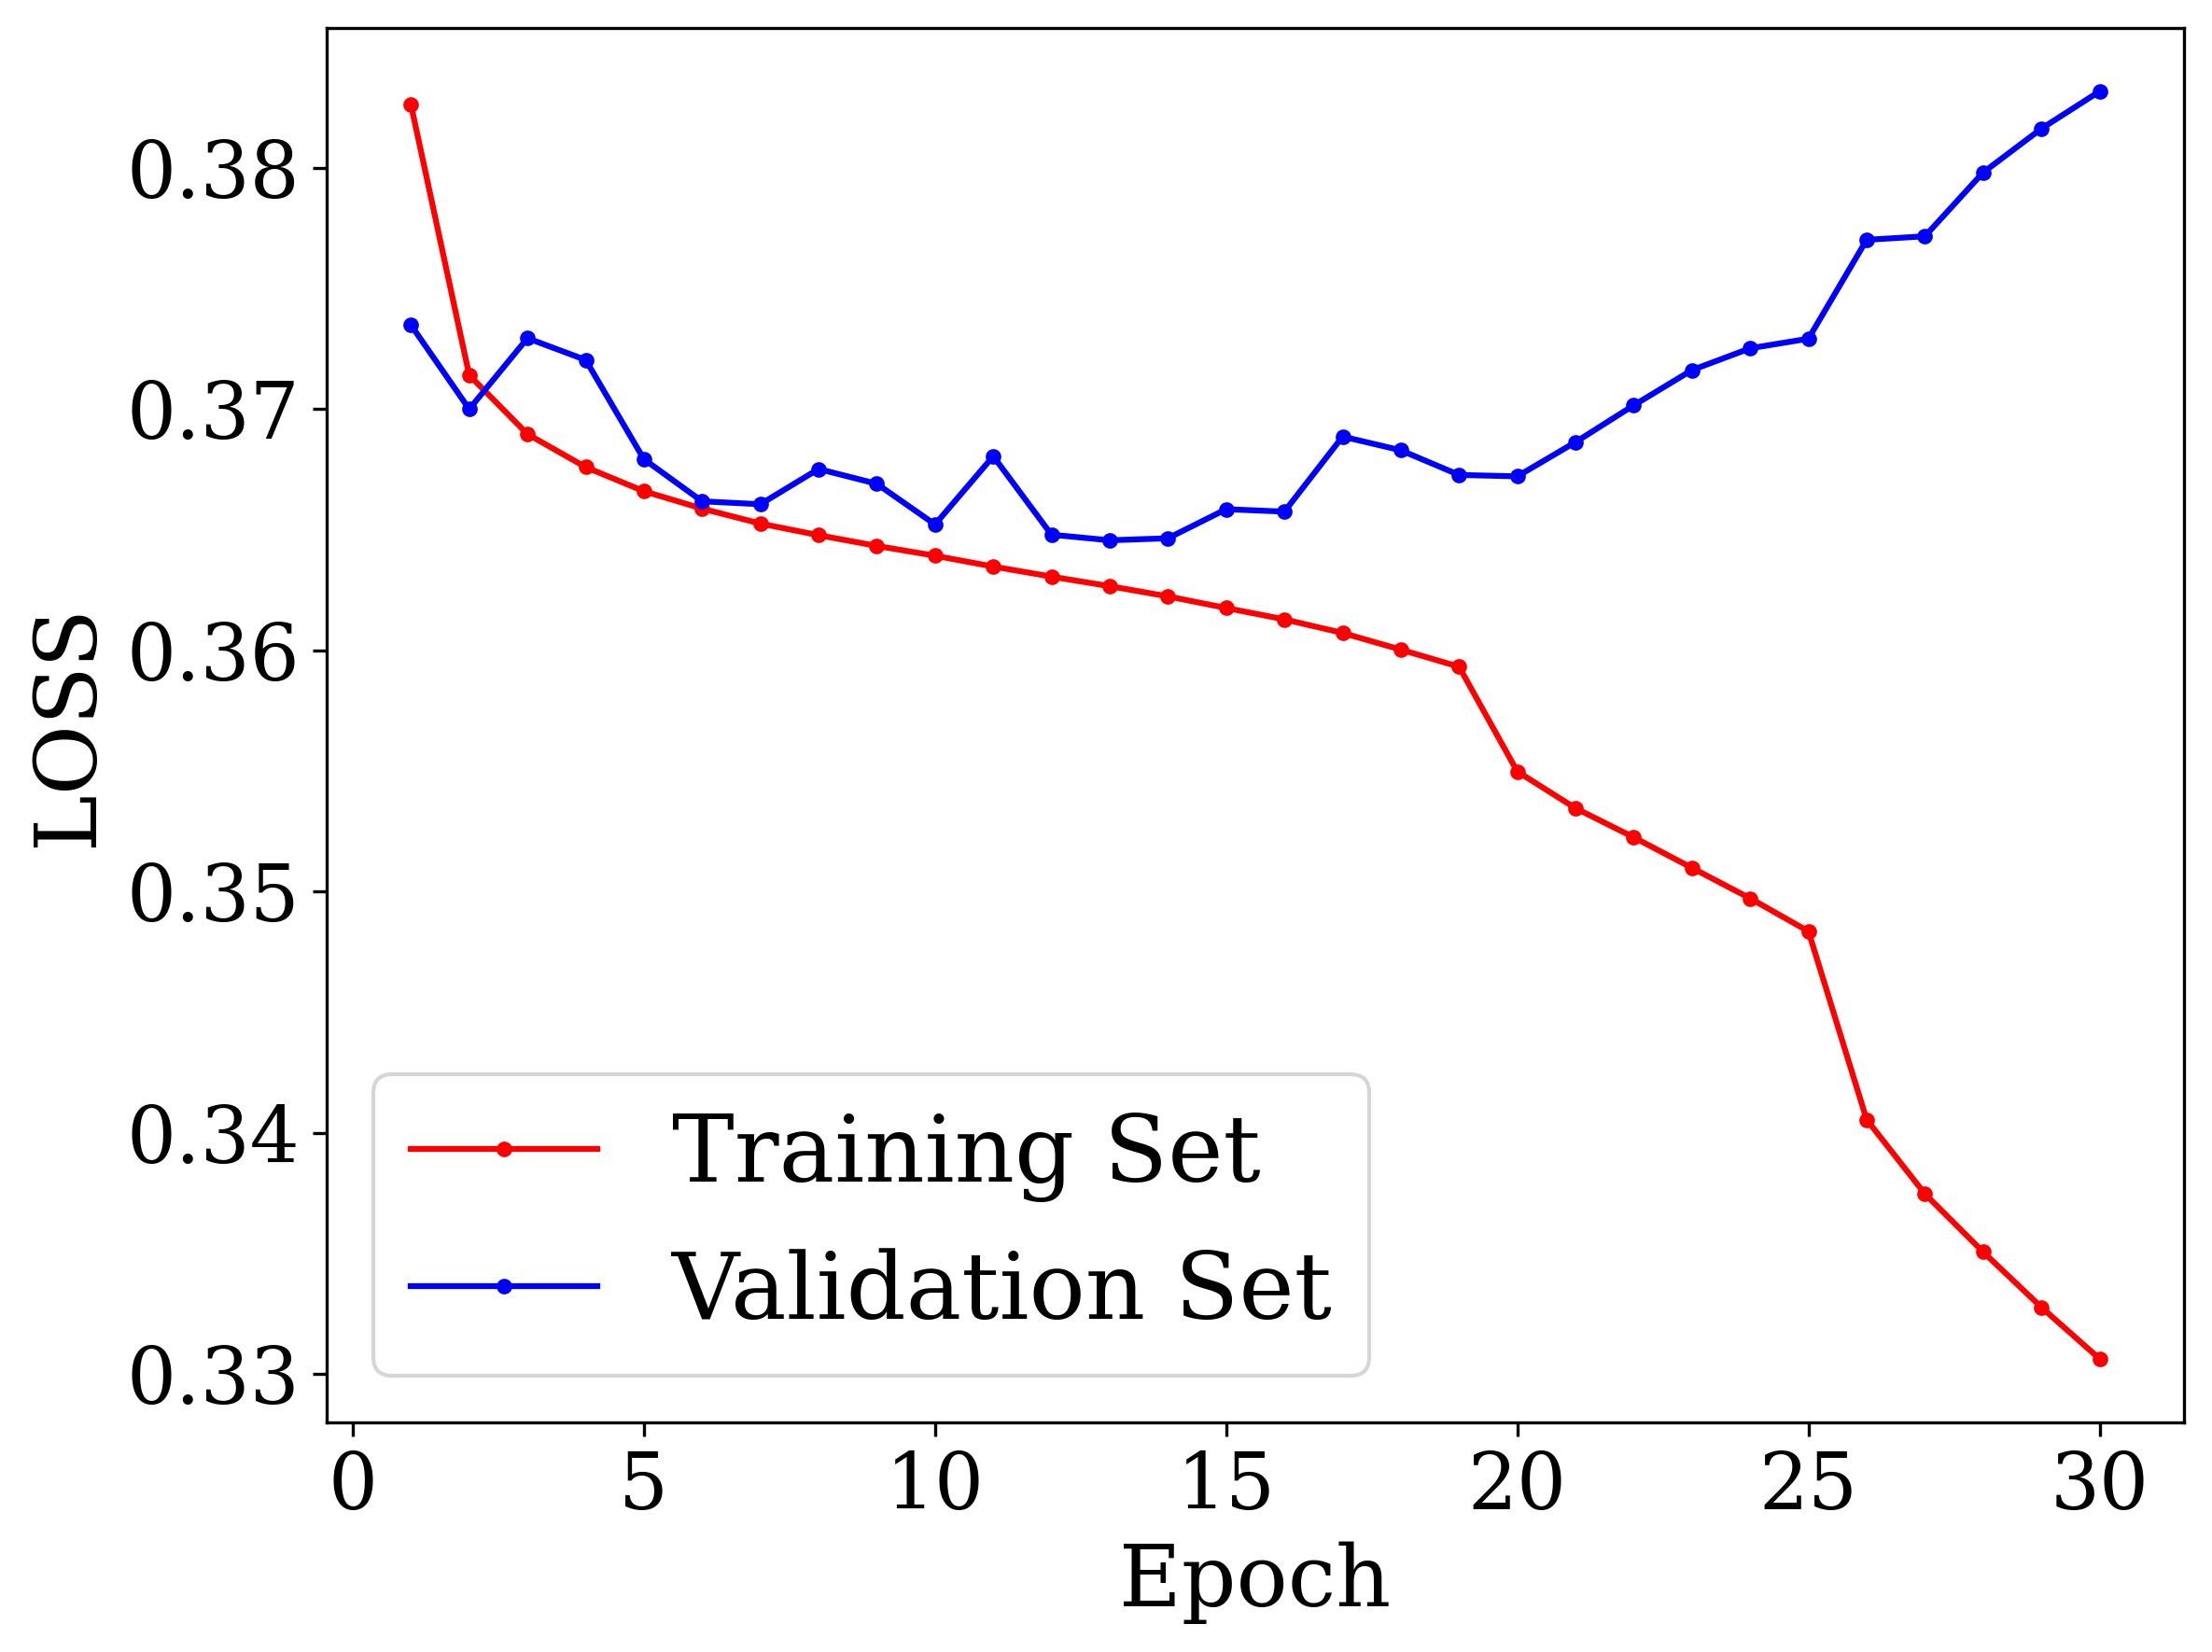

In [5]:
plt.figure(figsize=(8, 6))

plt.plot(epoch, train_losses, 'r.-', label="Training Set")
plt.plot(epoch, valid_losses, 'b.-', label='Validation Set')

plt.xlabel("Epoch", fontsize=22)
plt.ylabel("LOSS", fontsize=22)
plt.tick_params(axis='both',which='major',labelsize=20)
plt.xticks(np.arange(0, 31, 5))
plt.legend(fontsize=24)
plt.tight_layout()
plt.savefig(join(fig_dir, f'losses/{stem}_loss.jpg'))
plt.show()

In [6]:
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "12356"
torch.cuda.set_device(0)
init_process_group(backend='nccl', rank=0, world_size=1)

In [7]:
model_file = join(model_dir, f'{stem}13')
model = load_model(path=model_file,strict=True, assign=True)

/home/wxs0703/kl-nn/cnn/modules/train_lilla.py:313: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path), strict=strict, assign=assign)


In [41]:
n_zeros = 0
for name, param in model.state_dict().items():
    n_zeros += torch.sum(param == 0)
    print(f"Parameter Name: {name}, Shape: {param.shape}")
print(n_zeros)

Parameter Name: cnn_img.0.weight, Shape: torch.Size([32, 1, 3, 3])
Parameter Name: cnn_img.1.weight, Shape: torch.Size([32])
Parameter Name: cnn_img.1.bias, Shape: torch.Size([32])
Parameter Name: cnn_img.1.running_mean, Shape: torch.Size([32])
Parameter Name: cnn_img.1.running_var, Shape: torch.Size([32])
Parameter Name: cnn_img.1.num_batches_tracked, Shape: torch.Size([])
Parameter Name: cnn_img.3.weight, Shape: torch.Size([32, 32, 3, 3])
Parameter Name: cnn_img.4.weight, Shape: torch.Size([32])
Parameter Name: cnn_img.4.bias, Shape: torch.Size([32])
Parameter Name: cnn_img.4.running_mean, Shape: torch.Size([32])
Parameter Name: cnn_img.4.running_var, Shape: torch.Size([32])
Parameter Name: cnn_img.4.num_batches_tracked, Shape: torch.Size([])
Parameter Name: cnn_img.7.cnn1.0.weight, Shape: torch.Size([64, 32, 3, 3])
Parameter Name: cnn_img.7.cnn1.1.weight, Shape: torch.Size([64])
Parameter Name: cnn_img.7.cnn1.1.bias, Shape: torch.Size([64])
Parameter Name: cnn_img.7.cnn1.1.running_m

In [39]:
print(model.state_dict()['cnn_img.0.weight'])

tensor([[[[-0.0596, -0.1097,  0.2277],
          [-0.1767, -0.3183, -0.2395],
          [ 0.2076, -0.0742,  0.2574]]],


        [[[-0.0623, -0.0008, -0.2776],
          [-0.1437, -0.3152,  0.0810],
          [ 0.2825,  0.1182, -0.2791]]],


        [[[ 0.1181, -0.2278,  0.2902],
          [-0.2479,  0.0841,  0.0267],
          [ 0.3616,  0.1565, -0.1209]]],


        [[[-0.0027, -0.1043, -0.0893],
          [ 0.1399,  0.2284, -0.1780],
          [ 0.0942, -0.1116, -0.2985]]],


        [[[-0.0949,  0.3116,  0.1644],
          [ 0.0325,  0.1714, -0.0130],
          [ 0.3205, -0.0740,  0.2160]]],


        [[[-0.3206,  0.2885, -0.2642],
          [-0.0201, -0.2087, -0.1533],
          [-0.2598,  0.0349,  0.0610]]],


        [[[-0.1256, -0.1779, -0.1484],
          [-0.0110, -0.3075,  0.0383],
          [ 0.0537, -0.0364,  0.0309]]],


        [[[-0.1269, -0.1950, -0.2252],
          [ 0.1073, -0.2272,  0.1384],
          [-0.3159, -0.2237, -0.2225]]],


        [[[-0.0822, -0.2006, -0.

In [11]:
# Get data loader
test_args = list(config.test.values())
test_ds = pxt.TorchDataset(data_dir)
test_dl = DataLoader(test_ds,
                     batch_size=200,
                     pin_memory=True,
                     shuffle=False,)

In [12]:
len(test_ds)

100000

In [13]:
pred, true, loss = predict(8, test_dl, model)
print('Test LOSS:',loss)

Test LOSS: 0.3646464585106001


In [14]:
diff = pred - true

In [15]:
par_ranges = config.par_ranges

In [16]:
def denormalize(samples):
    denorm = np.empty_like(samples)
    denorm[:, 0] = samples[:, 0]
    for i, par in enumerate(par_ranges.values()):
        low, high = par
        values = samples[:, i+1]
        values += 1
        values *= (high-low)/2
        values += low
        denorm[:, i+1] = values
    return denorm

In [17]:
pred_den = denormalize(pred)
true_den = denormalize(true)

In [18]:
diff = pred_den - true_den

In [19]:
destroy_process_group()

In [20]:
SNR = np.zeros((100000,), dtype=np.float32)
with px.Reader(data_dir) as db:
    for i in range(100000):
        SNR[i] = db[i]['SNR']

In [21]:
SNR = SNR[pred[:, 0].astype(int)]

In [22]:
os.system(f'mkdir /data/wxs0703/kl-nn/figures/{stem}')

0

In [23]:
def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
        
    Example Usage
    -------------
     density_contour(x pos, y pos, contour res, contour res, axis, colors for contours)
     e.g.:
     density_contour(xD, yD, 80, 80, ax=ax, 
         colors=['red','orange', 'yellow', 'orange', 'yellow'])

    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), density=True)
    # NOTE : if you are using the latest version of python, in the above: 
    # instead of normed=True, use density=True
    
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))
    
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    
    ### Adjust Here #### 
    
    # Contour Levels Definitions
    zero = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.))
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))


    # Array of Contour levels. Adjust according to the above
    levels = [zero, one_sigma, two_sigma][::-1]

    ###### 
    
    if ax == None:
        contour = plt.contourf(X, Y, Z, levels=levels, origin="lower", alpha=0.5, **contour_kwargs)

    else:
        contour = ax.contourf(X, Y, Z, levels=levels, origin="lower", alpha=0.5, **contour_kwargs)
    
    return contour

### g1, g2

<Figure size 2100x1800 with 0 Axes>

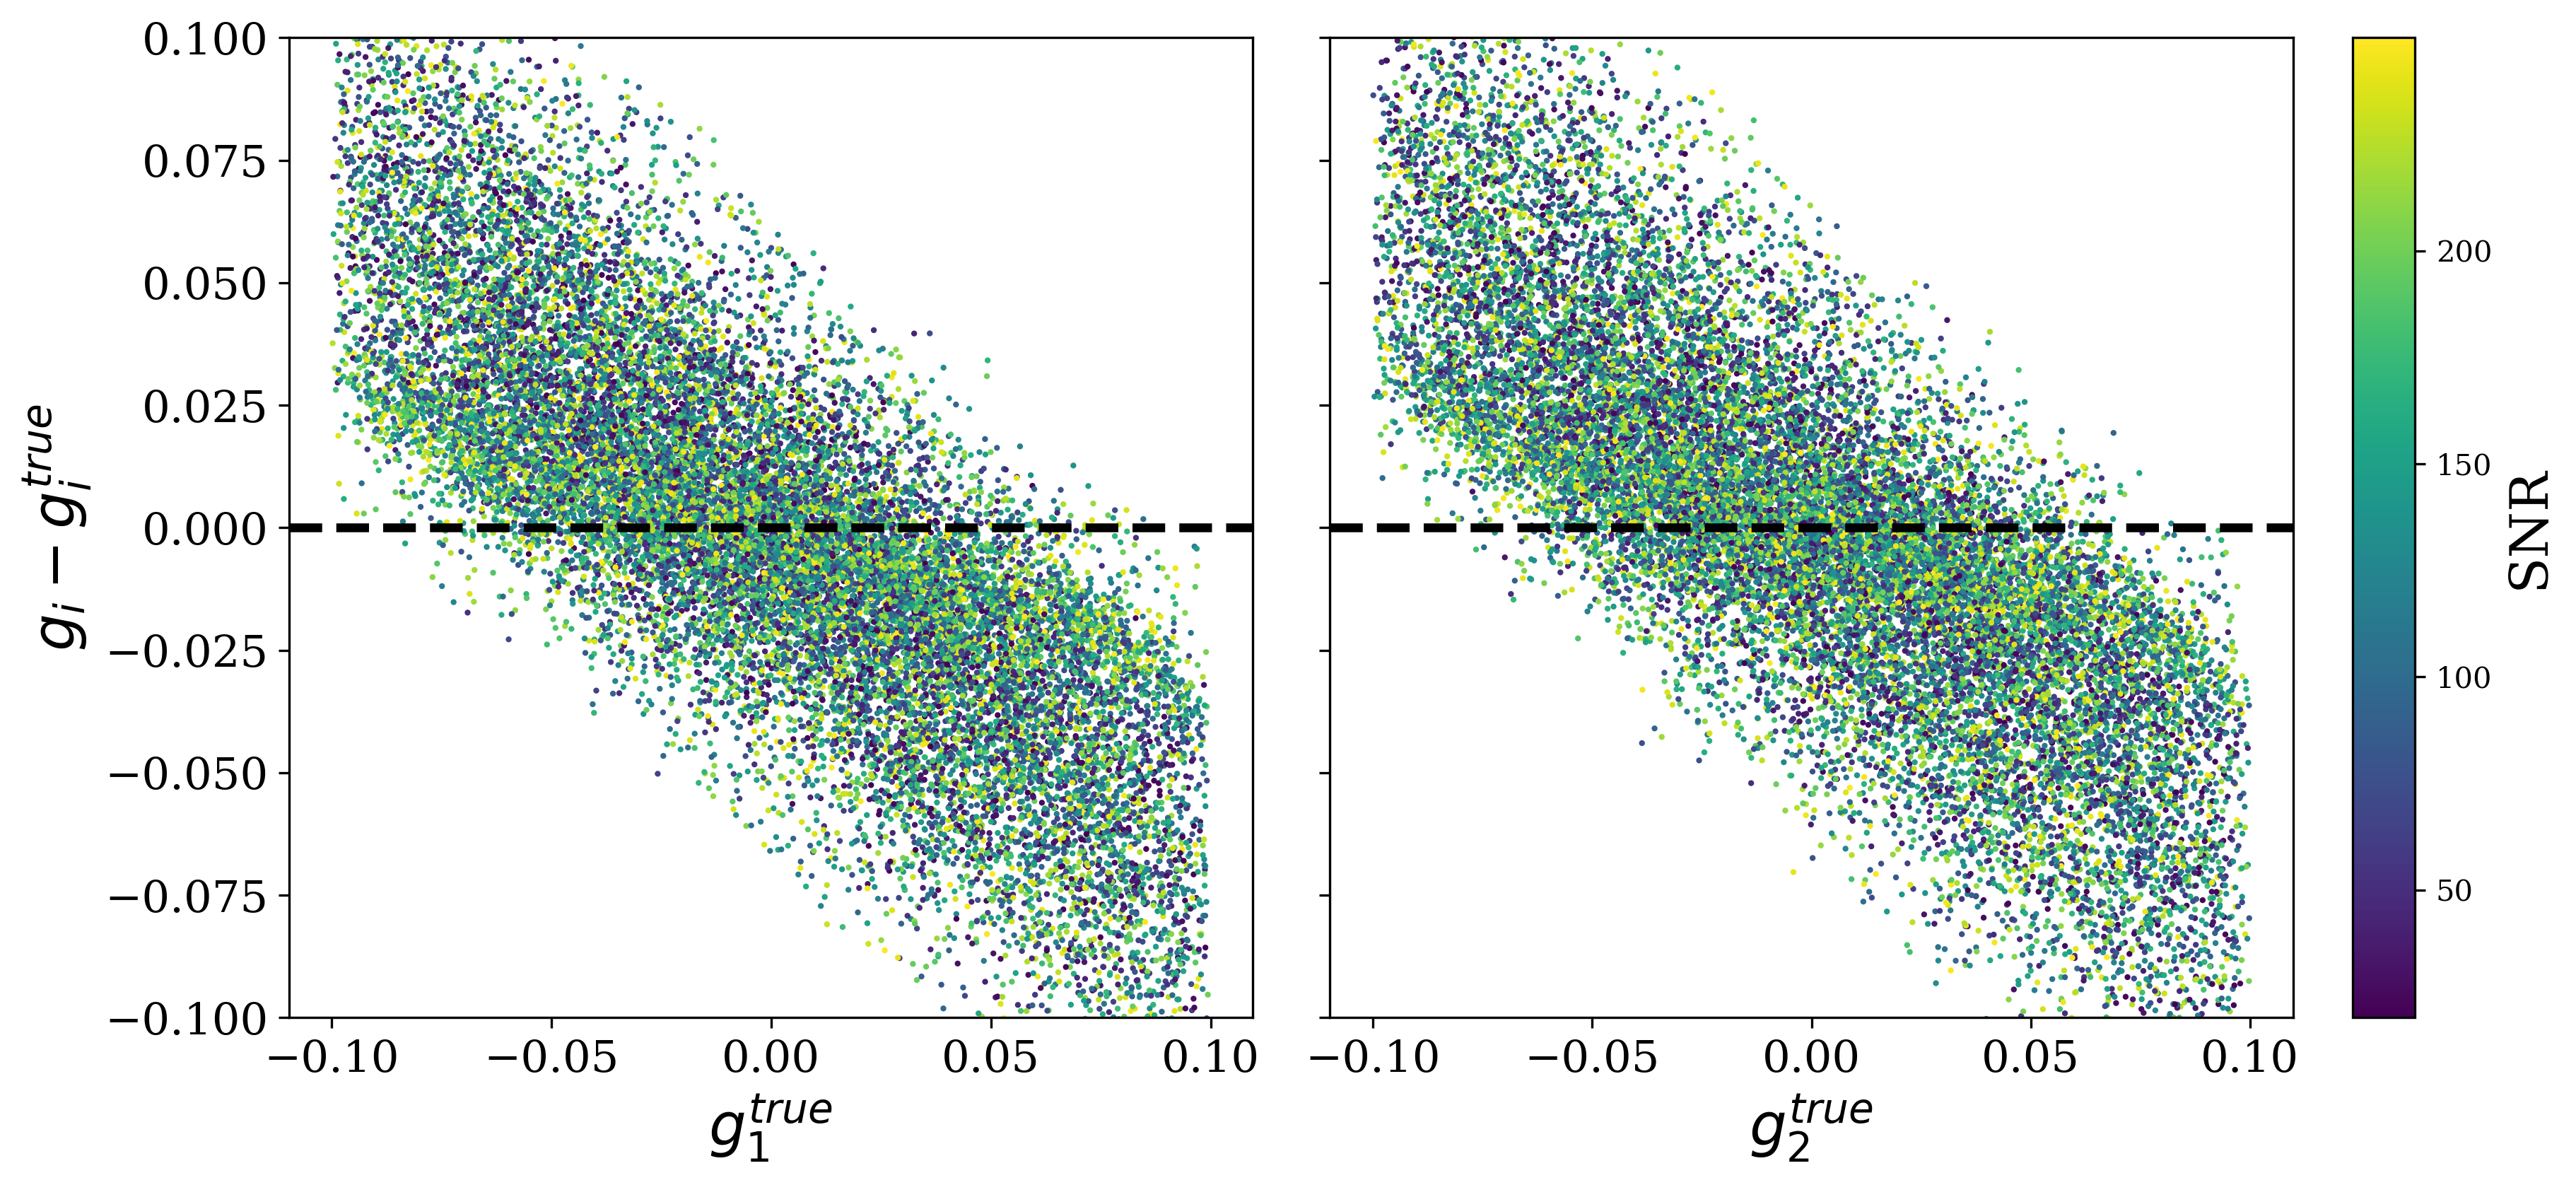

In [34]:
plt.rcParams.update({"text.usetex": False, "font.family": "serif", "figure.dpi": 300})
fig = plt.figure(figsize=(7,6))
fig1,axes = plt.subplots(1,2,sharey=True,figsize=(14,6))

g1_true = true[:,1]
g1_diff = diff[:,1]
g2_true = true[:,2]
g2_diff = diff[:,2]

axes[0].scatter(g1_true[:20000], g1_diff[:20000], c=SNR[:20000], s=1, cmap='viridis')
sc = axes[1].scatter(g2_true[:20000], g2_diff[:20000], c=SNR[:20000], s=1, cmap='viridis')
axes[0].set_ylim(-0.1,.1)

for i in range(2):
    axes[i].axhline(0,color='k',linestyle='--',linewidth=3)
    
axes[0].set_xlabel(r'$g_1^{true}$',fontsize=20)
axes[1].set_xlabel(r'$g_2^{true}$',fontsize=20)
axes[0].set_ylabel(r'$g_i-g_i^{true}$',fontsize=20)

axes[0].tick_params(axis='both',which='major',labelsize=15)
axes[1].tick_params(axis='x',which='major',labelsize=15)

left, bottom, width, height = axes[1].get_position().bounds
cax = fig1.add_axes([0.82, bottom, width*0.06, height])
cbar = plt.colorbar(sc, orientation='vertical', cax=cax)
cbar.ax.set_ylabel(r'SNR', fontsize=18)

fig1.subplots_adjust(wspace=0.08,hspace=0.06)

fig1.subplots_adjust(right=0.8)

plt.savefig(join(fig_dir, f'{stem}/g_{stem}_SNR.jpg'))
plt.show()

<Figure size 2400x1800 with 0 Axes>

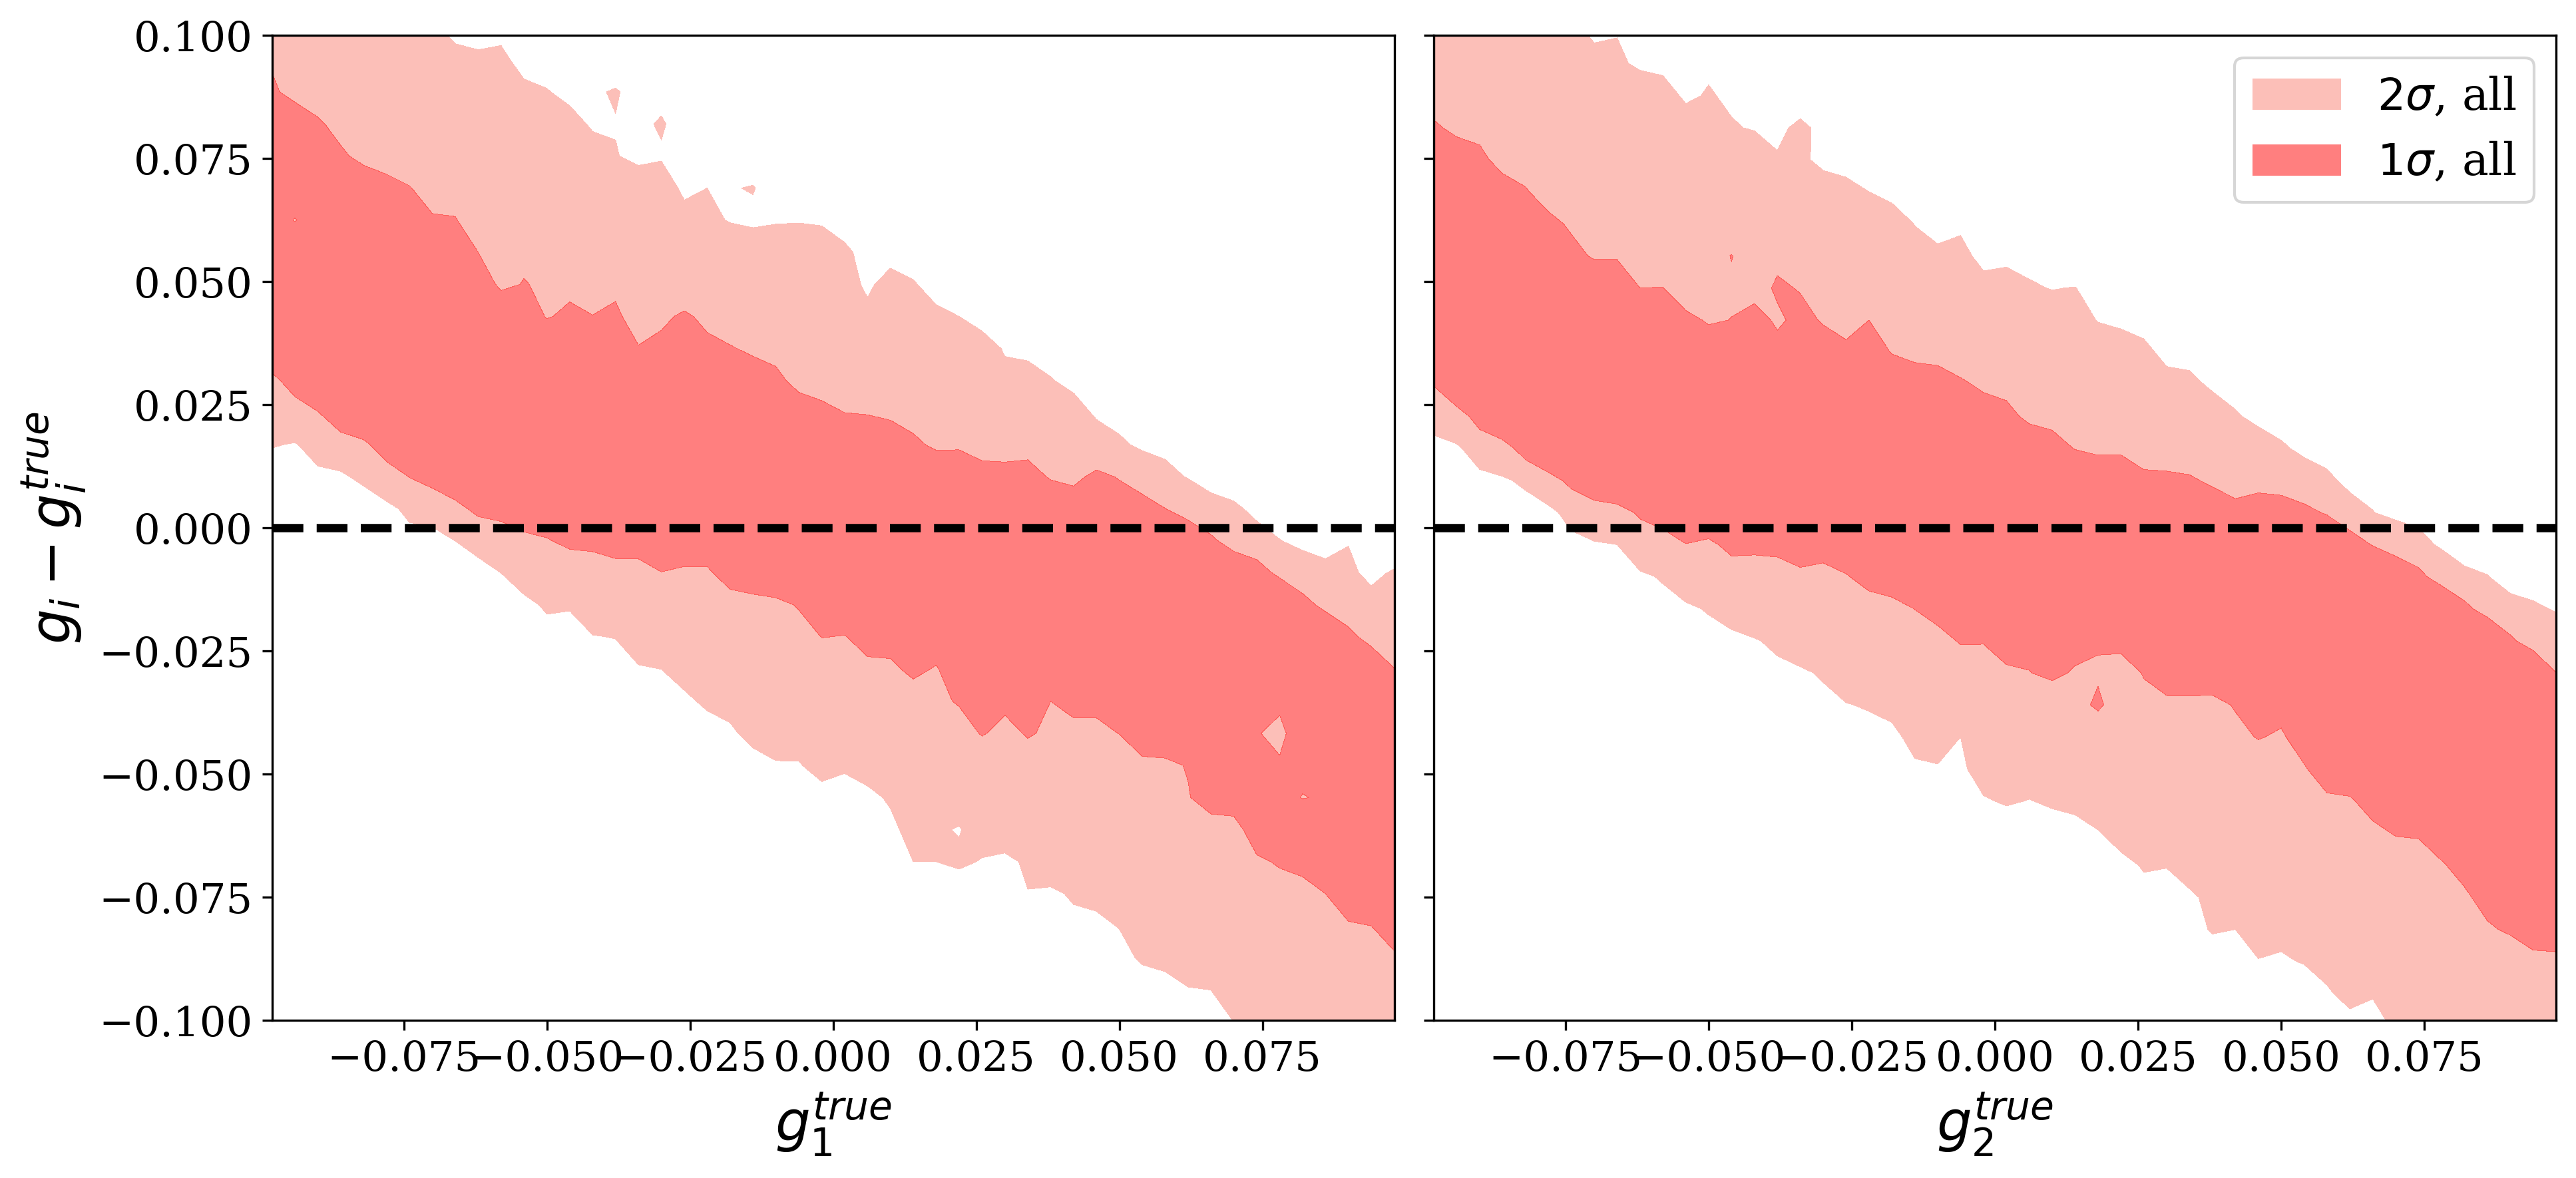

In [25]:
plt.rcParams.update({"text.usetex": False, "font.family": "serif", "figure.dpi": 300})
fig = plt.figure(figsize=(8,6))
fig1,axes = plt.subplots(1,2,sharey=True,figsize=(13,6))

g1_true = true[:,1]
g1_diff = diff[:,1]
g2_true = true[:,2]
g2_diff = diff[:,2]

density_contour(g1_true, g1_diff, 50, 50, ax=axes[0], colors=['salmon', 'red'])
contour = density_contour(g2_true, g2_diff, 50, 50, ax=axes[1], colors=['salmon', 'red'])
axes[0].set_ylim(-0.1,0.1)

for i in range(2):
    axes[i].axhline(0,color='k',linestyle='--',linewidth=3)
    
axes[0].set_xlabel(r'$g_1^{true}$',fontsize=20)
axes[1].set_xlabel(r'$g_2^{true}$',fontsize=20)
axes[0].set_ylabel(r'$g_i-g_i^{true}$',fontsize=20)

axes[0].tick_params(axis='both',which='major',labelsize=15)
axes[1].tick_params(axis='x',which='major',labelsize=15)

handles, _ = contour.legend_elements()
plt.legend(handles, [r'$2\sigma$, all', r'$1\sigma$, all'], fontsize=16)

fig1.subplots_adjust(wspace=0.08,hspace=0.06)

fig1.subplots_adjust(right=0.8)

plt.tight_layout()
plt.savefig(join(fig_dir, f'{stem}/g_{stem}_contour.jpg'))
plt.show()

<Figure size 2400x1800 with 0 Axes>

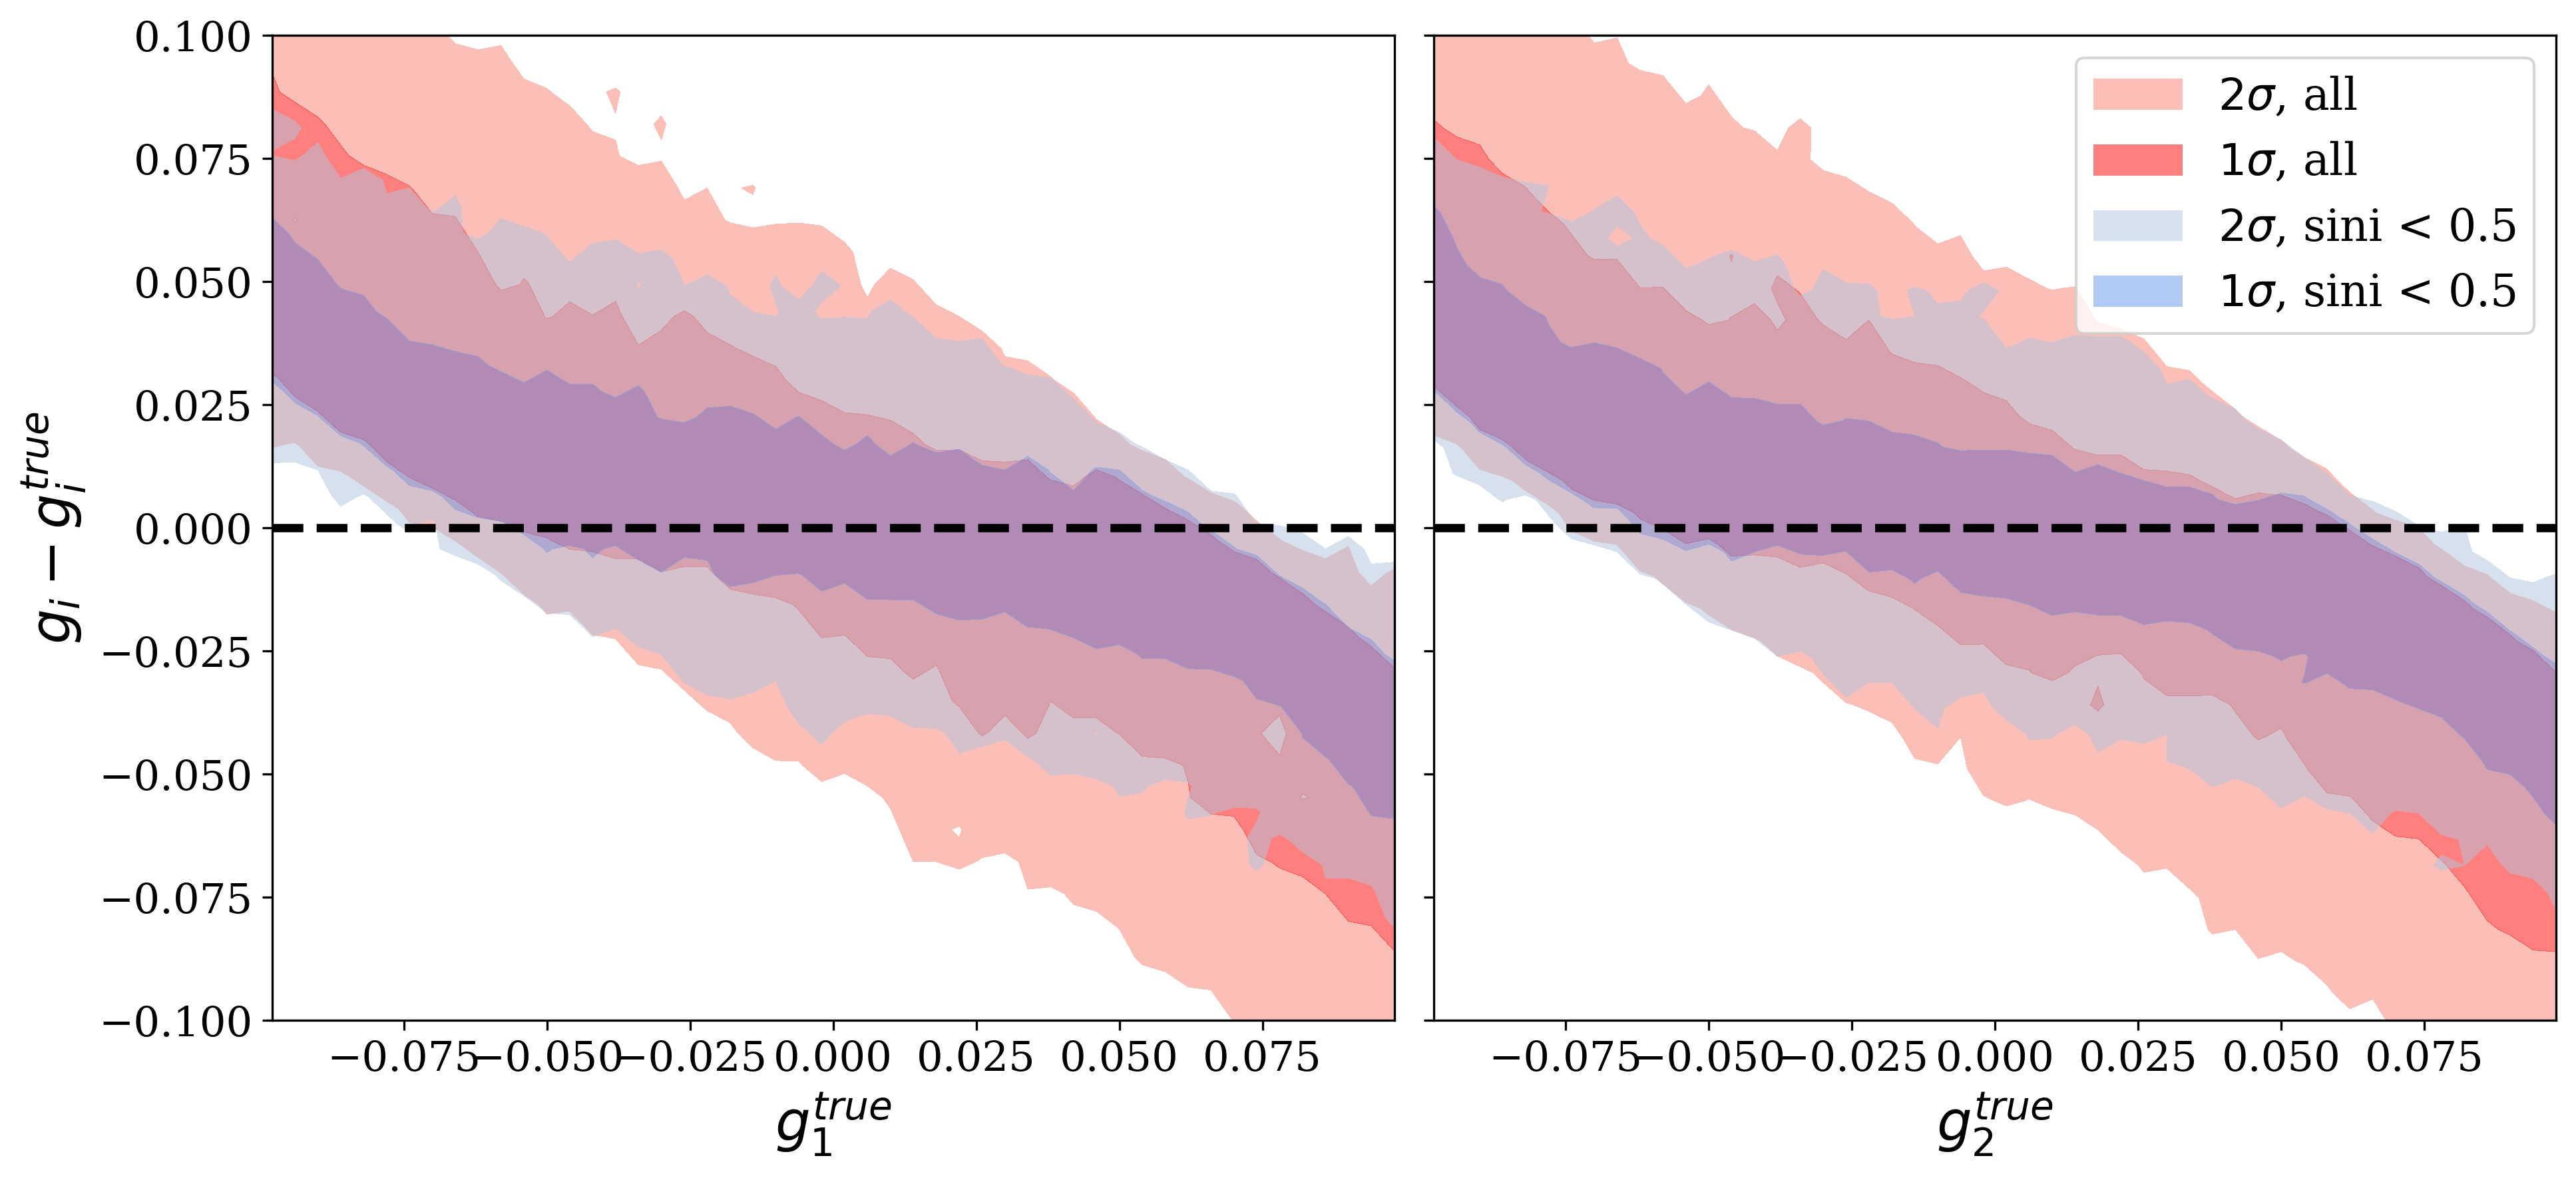

In [24]:
plt.rcParams.update({"text.usetex": False, "font.family": "serif", "figure.dpi": 300})
fig = plt.figure(figsize=(8,6))
fig1,axes = plt.subplots(1,2,sharey=True,figsize=(13,6))

g1_true = true[:,1]
g1_diff = diff[:,1]
g2_true = true[:,2]
g2_diff = diff[:,2]
sini_mask = true[:, 4] < 0.5

density_contour(g1_true, g1_diff, 50, 50, ax=axes[0], colors=['salmon', 'red'])
contour = density_contour(g2_true, g2_diff, 50, 50, ax=axes[1], colors=['salmon', 'red'])
density_contour(g1_true[sini_mask], g1_diff[sini_mask], 50, 50, ax=axes[0], colors=['lightsteelblue', 'cornflowerblue'])
contour1 = density_contour(g2_true[sini_mask], g2_diff[sini_mask], 50, 50, ax=axes[1], colors=['lightsteelblue', 'cornflowerblue'])
axes[0].set_ylim(-0.1,0.1)

for i in range(2):
    axes[i].axhline(0,color='k',linestyle='--',linewidth=3)
    
axes[0].set_xlabel(r'$g_1^{true}$',fontsize=20)
axes[1].set_xlabel(r'$g_2^{true}$',fontsize=20)
axes[0].set_ylabel(r'$g_i-g_i^{true}$',fontsize=20)

axes[0].tick_params(axis='both',which='major',labelsize=15)
axes[1].tick_params(axis='x',which='major',labelsize=15)

handles, _ = contour.legend_elements()
handles1, _ = contour1.legend_elements()
handles += handles1
plt.legend(handles, [r'$2\sigma$, all', r'$1\sigma$, all', 
                     r'$2\sigma$, sini < 0.5', r'$1\sigma$, sini < 0.5'], fontsize=16)

fig1.subplots_adjust(wspace=0.08,hspace=0.06)

fig1.subplots_adjust(right=0.8)

plt.tight_layout()
plt.savefig(join(fig_dir, f'{stem}/g_{stem}_contour_2.jpg'))
plt.show()

### theta_int

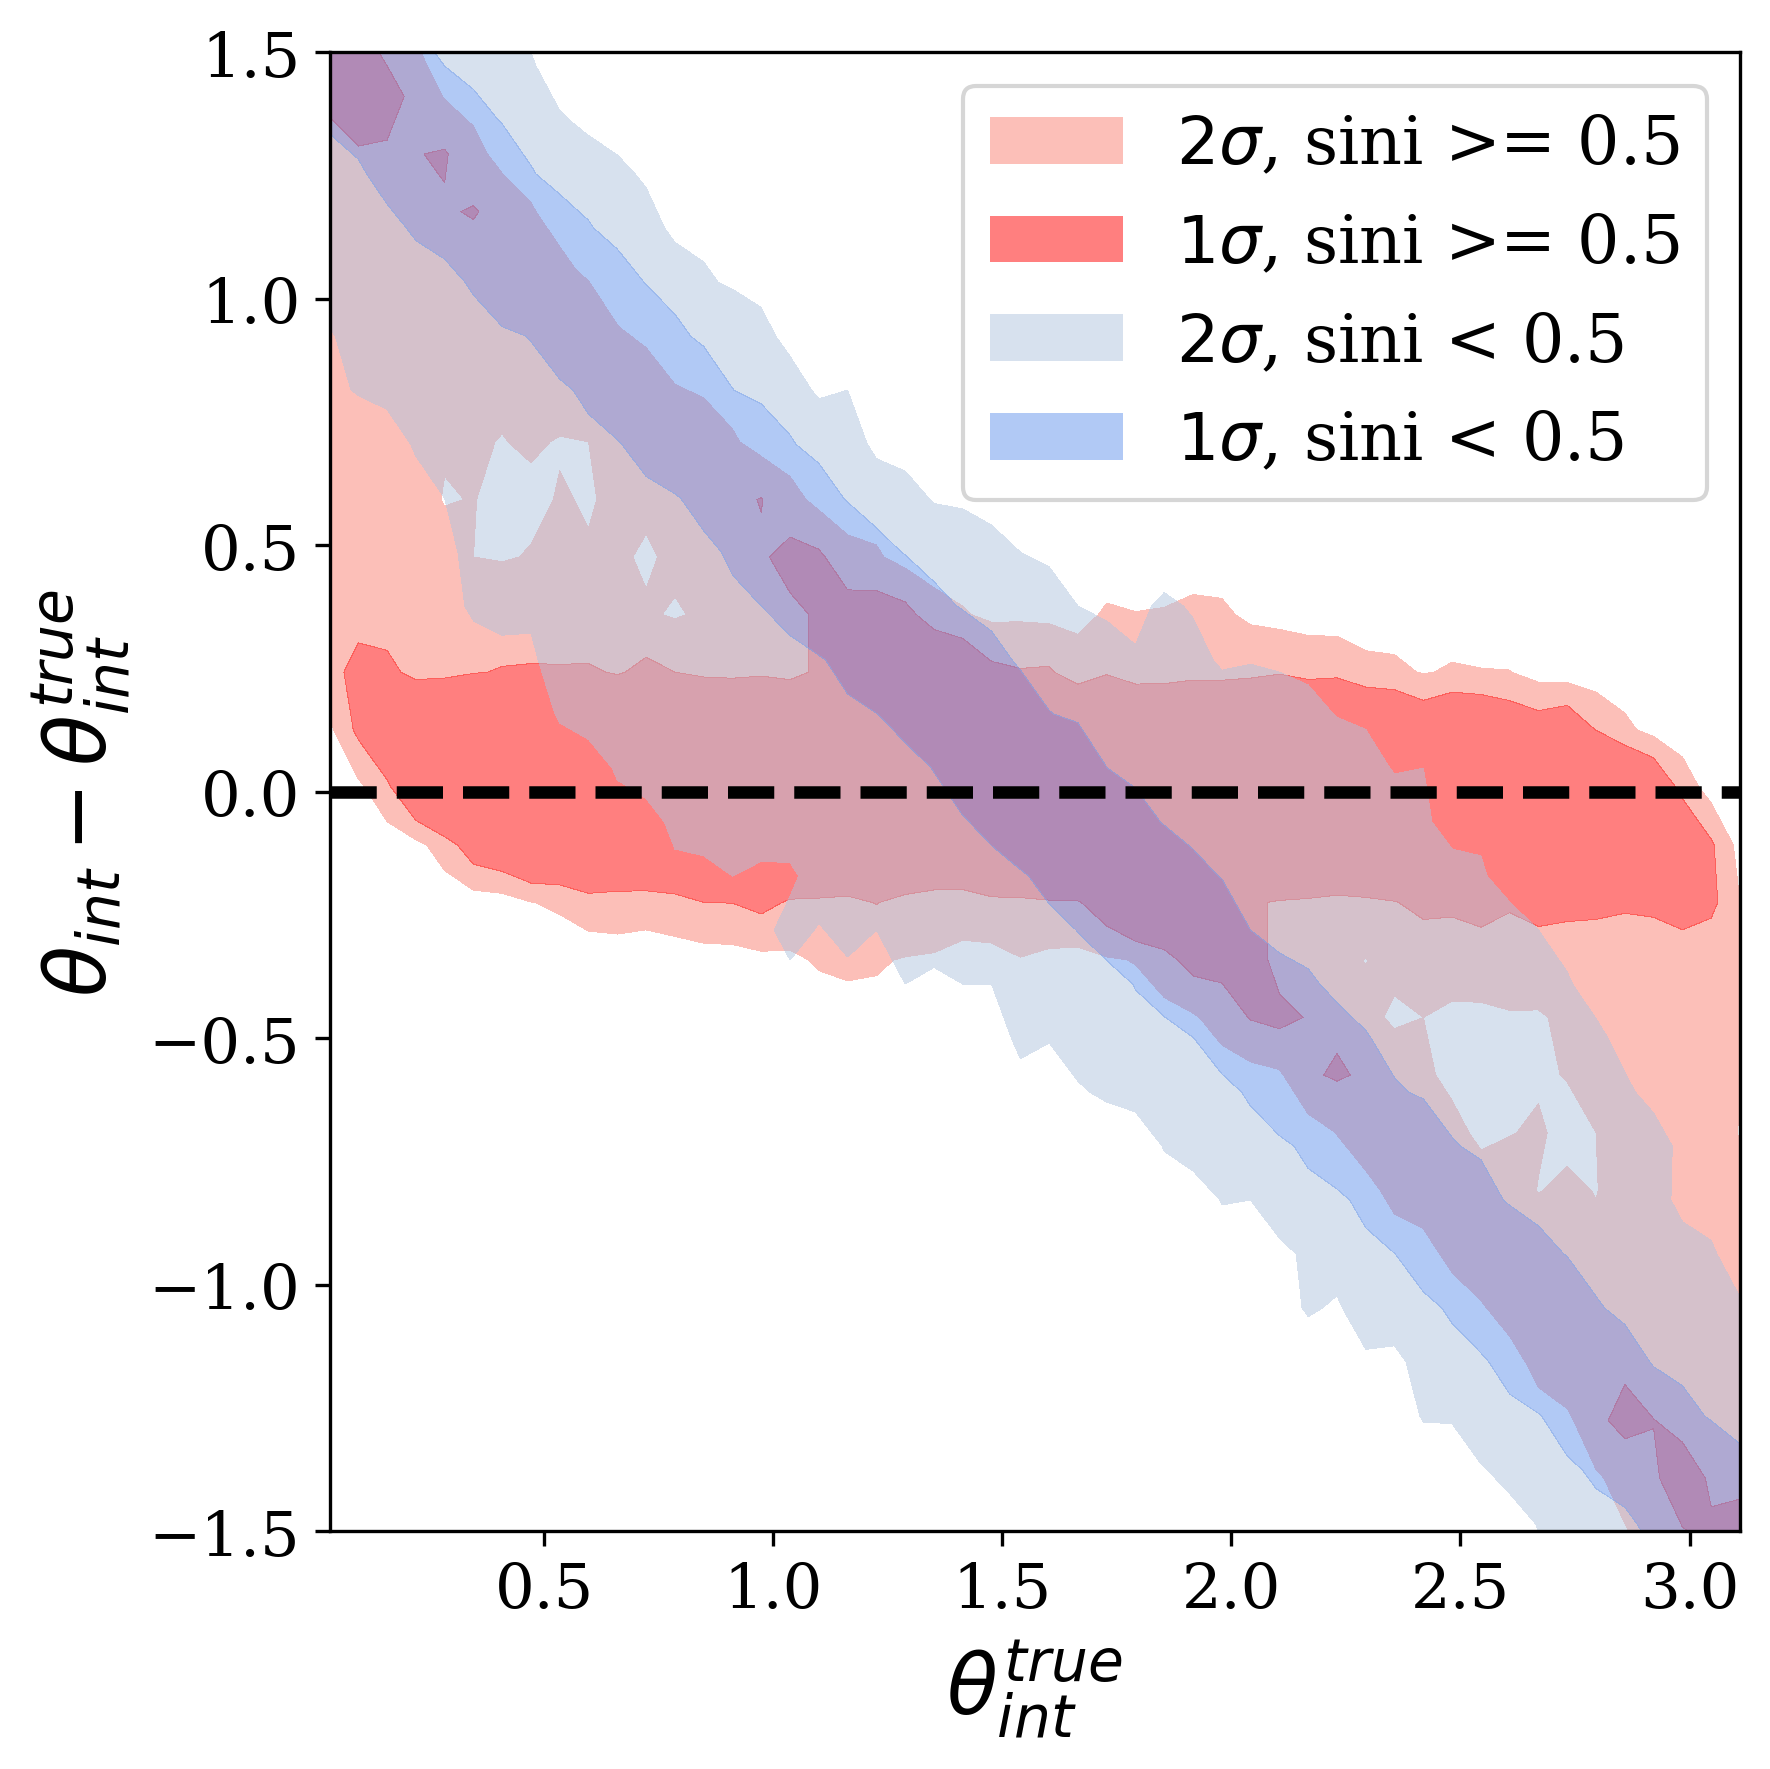

In [26]:
plt.rcParams.update({"text.usetex": False, "font.family": "serif", "figure.dpi": 300})
fig = plt.figure(figsize=(6,6))

theta_true = true[:,3]
theta_diff = diff[:,3]
sini_mask = true[:, 4] < 0.5

contour = density_contour(theta_true[~sini_mask], theta_diff[~sini_mask], 50, 50, colors=['salmon', 'red'])
contour1 = density_contour(theta_true[sini_mask], theta_diff[sini_mask], 50, 50, colors=['lightsteelblue', 'cornflowerblue'])
plt.ylim(-1.5, 1.5)

plt.axhline(0,color='k',linestyle='--',linewidth=3)
    
plt.xlabel(r'$\theta_{int}^{true}$',fontsize=20)
plt.ylabel(r'$\theta_{int}-\theta_{int}^{true}$',fontsize=20)

plt.tick_params(axis='both',which='major',labelsize=15)
plt.tick_params(axis='x',which='major',labelsize=15)

handles, _ = contour.legend_elements()
handles1, _ = contour1.legend_elements()
handles += handles1
plt.legend(handles, [r'$2\sigma$, sini >= 0.5', r'$1\sigma$, sini >= 0.5', 
                     r'$2\sigma$, sini < 0.5', r'$1\sigma$, sini < 0.5'], fontsize=16)

fig.subplots_adjust(wspace=0.08,hspace=0.06)

fig.subplots_adjust(right=0.8)

plt.tight_layout()
plt.savefig(join(fig_dir, f'{stem}/theta_{stem}_contour_2.jpg'))
plt.show()

### sini

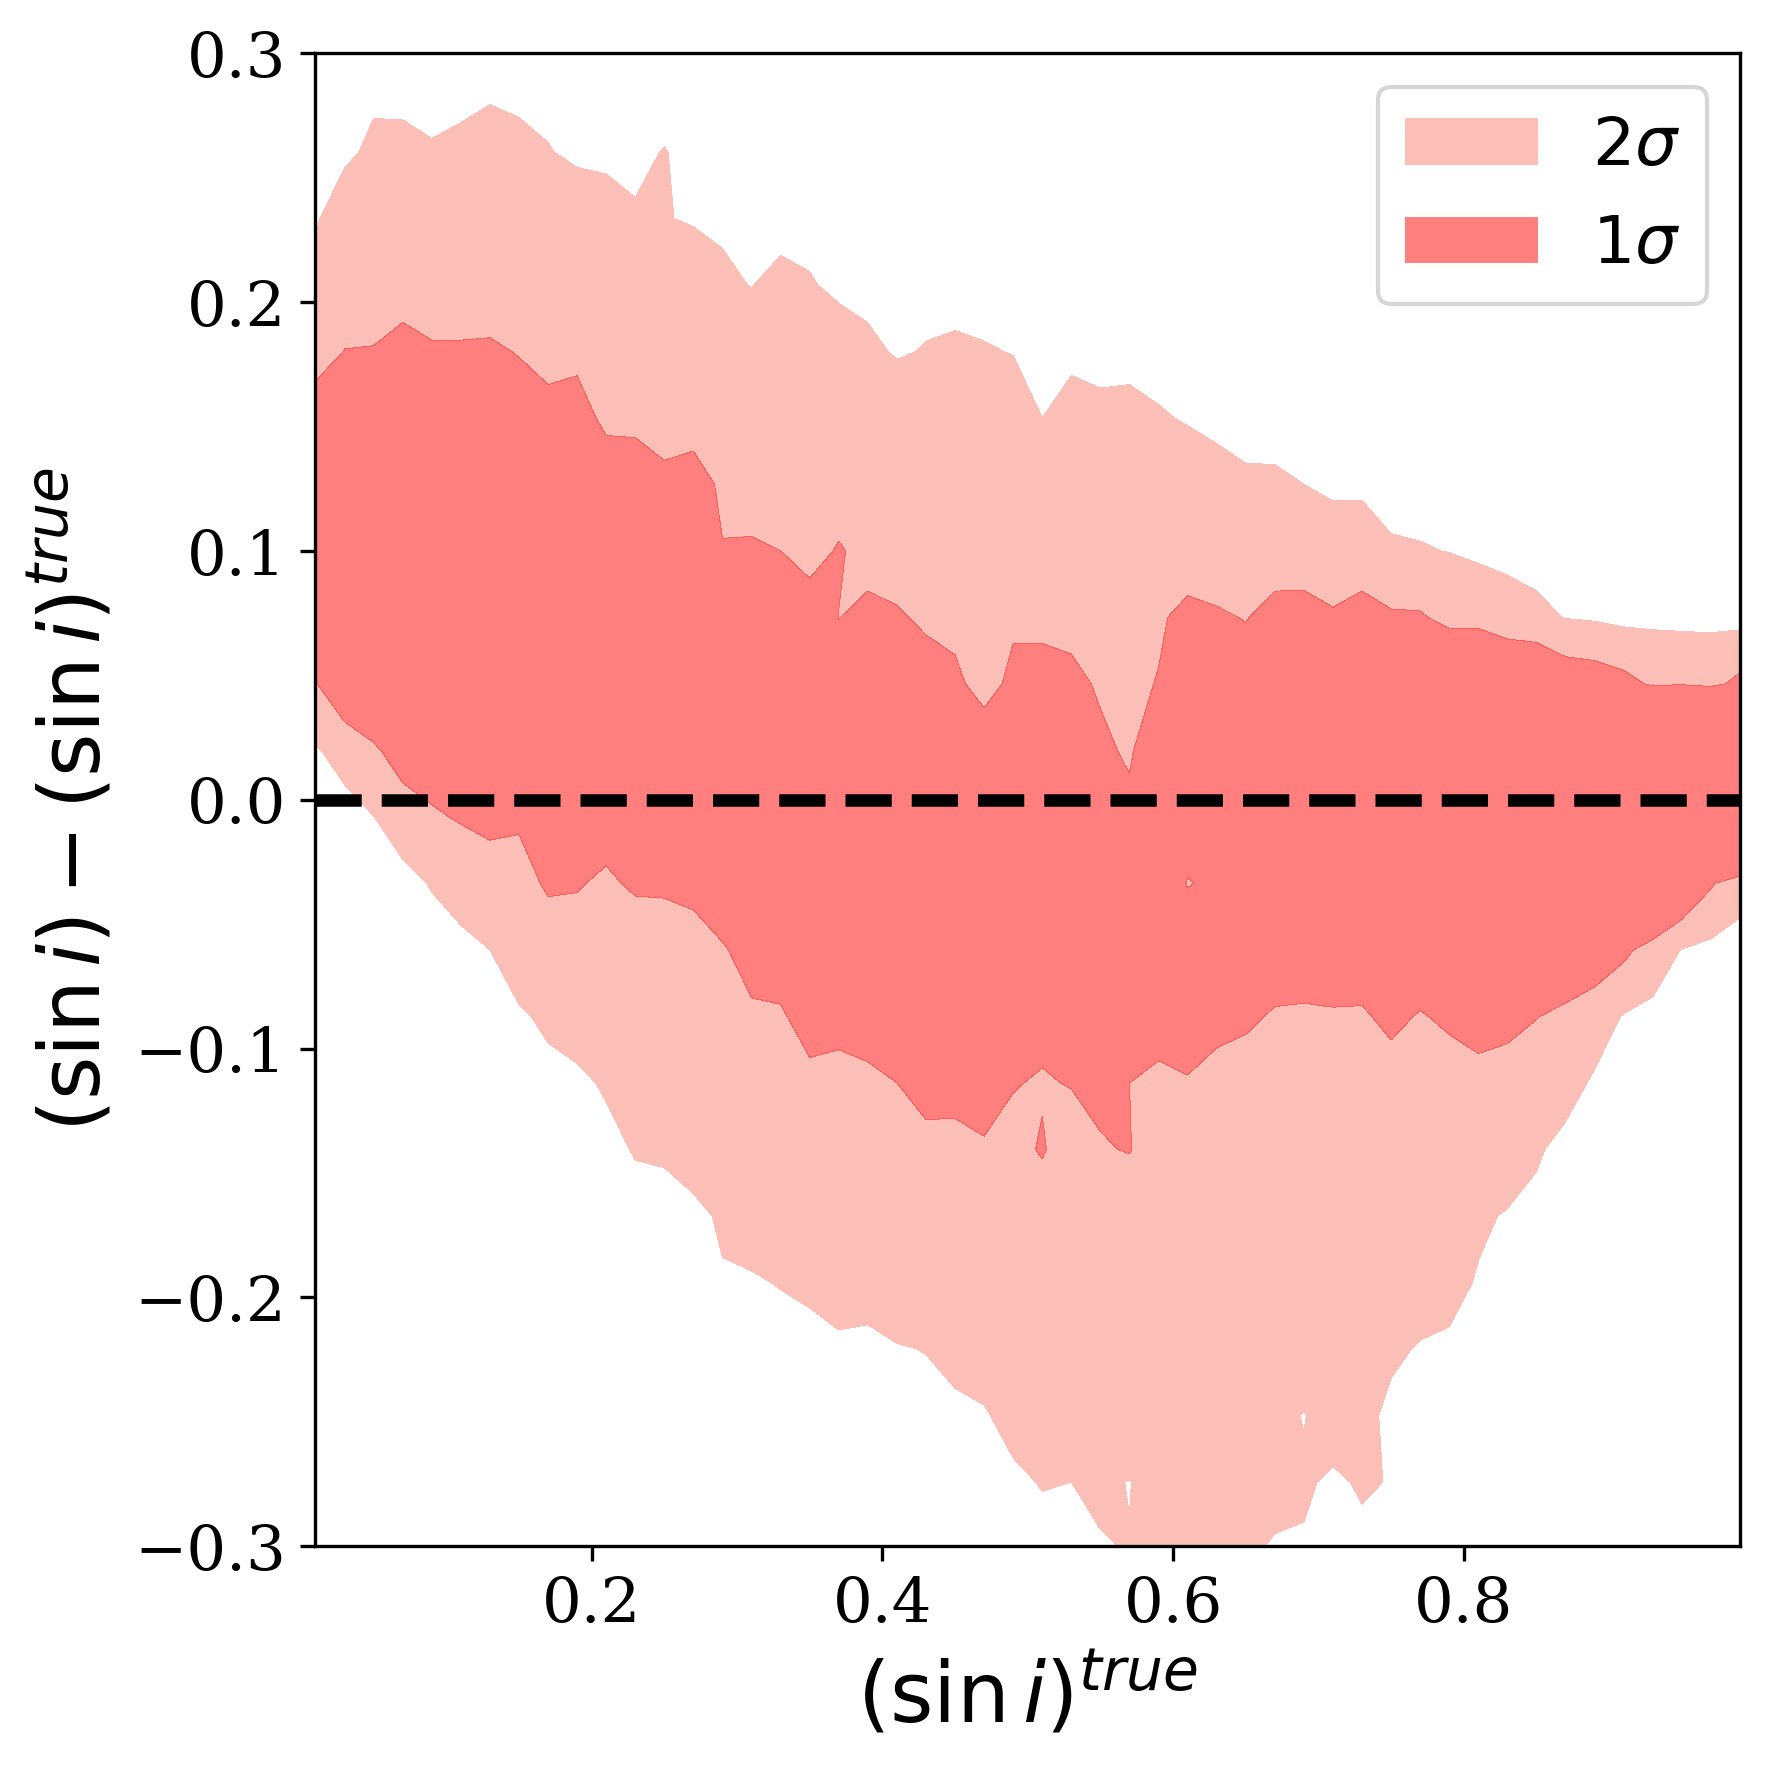

In [27]:
fig = plt.figure(figsize=(6,6))

sini_true = true[:,4]
sini_diff = diff[:,4]
contour = density_contour(sini_true, sini_diff, 50, 50, colors=['salmon', 'red'])
plt.ylim(-0.3,0.3)

plt.axhline(0,color='k',linestyle='--',linewidth=3)
    
plt.xlabel(r'$(\sin i)^{true}$',fontsize=20)
plt.ylabel(r'$(\sin i)-(\sin i)^{true}$',fontsize=20)

plt.tick_params(axis='both',which='major',labelsize=15)

handles, labels = contour.legend_elements()
plt.legend(handles, [r'$2\sigma$', r'$1\sigma$'], fontsize=16)

plt.tight_layout()
plt.savefig(join(fig_dir, f'{stem}/sini_{stem}_contour.jpg'))
plt.show()

### v0

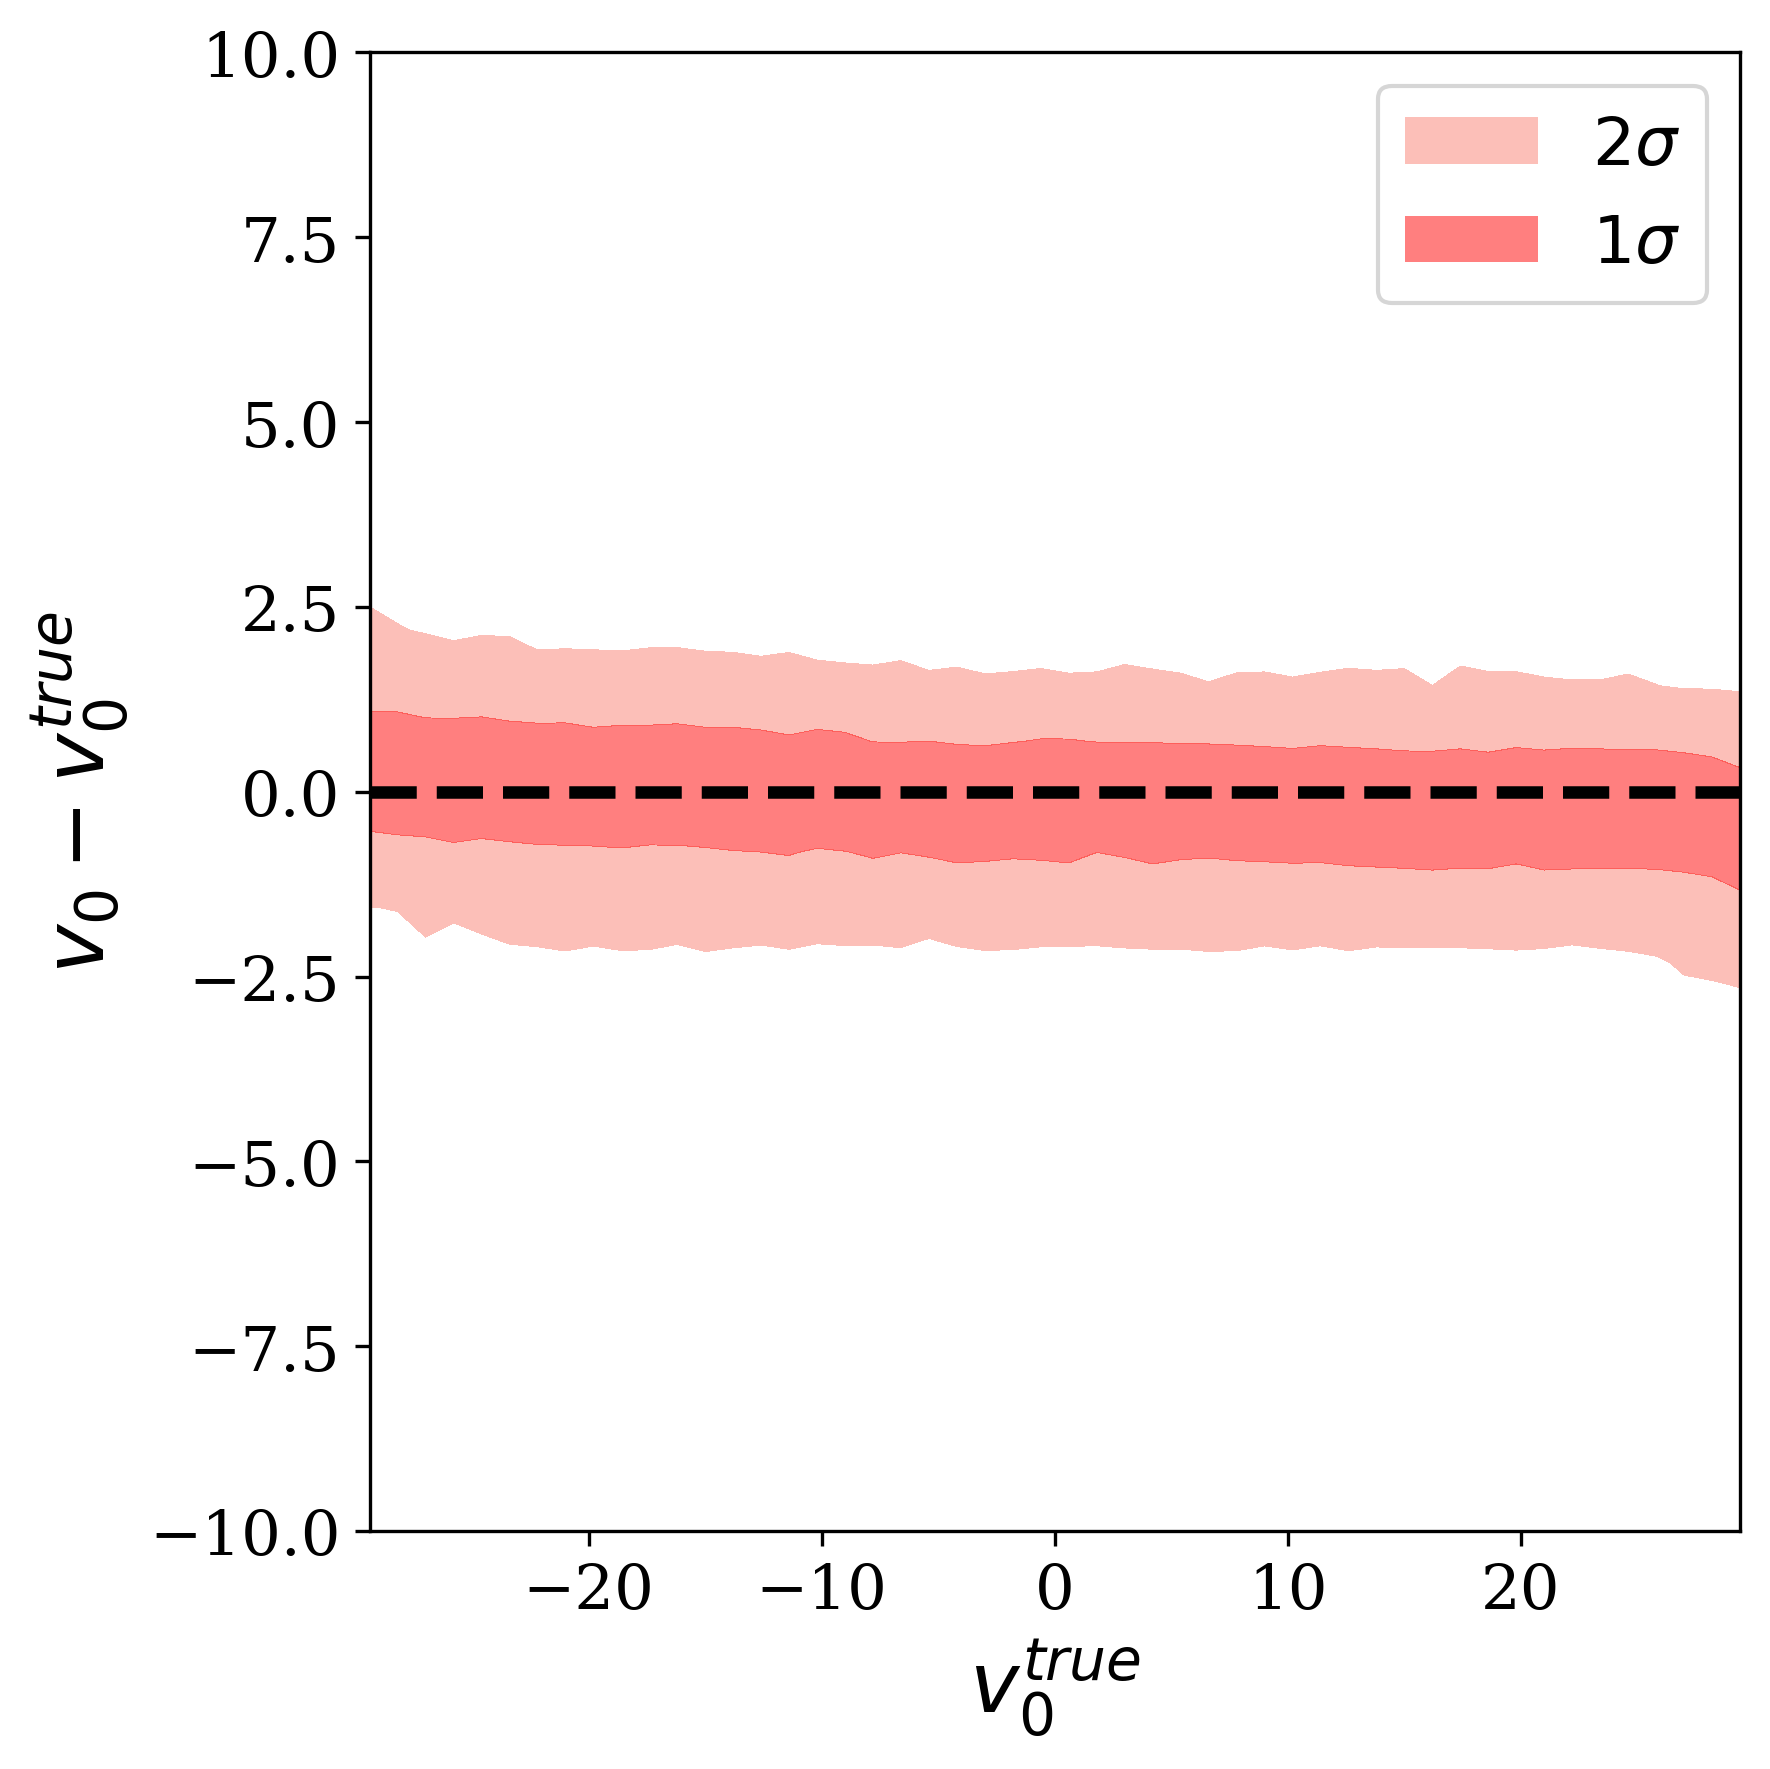

In [28]:
fig = plt.figure(figsize=(6,6))

v0_true = true[:,5]
v0_diff = diff[:,5]
contour = density_contour(v0_true, v0_diff, 50, 50, colors=['salmon', 'red'])
plt.ylim(-10,10)

plt.axhline(0,color='k',linestyle='--',linewidth=3)
    
plt.xlabel(r'$v_0^{true}$',fontsize=20)
plt.ylabel(r'$v_0-v_0^{true}$',fontsize=20)

plt.tick_params(axis='both',which='major',labelsize=15)

handles, labels = contour.legend_elements()
plt.legend(handles, [r'$2\sigma$', r'$1\sigma$'], fontsize=16)

plt.tight_layout()
plt.savefig(join(fig_dir, f'{stem}/v0_{stem}_contour.jpg'))
plt.show()

### vcirc

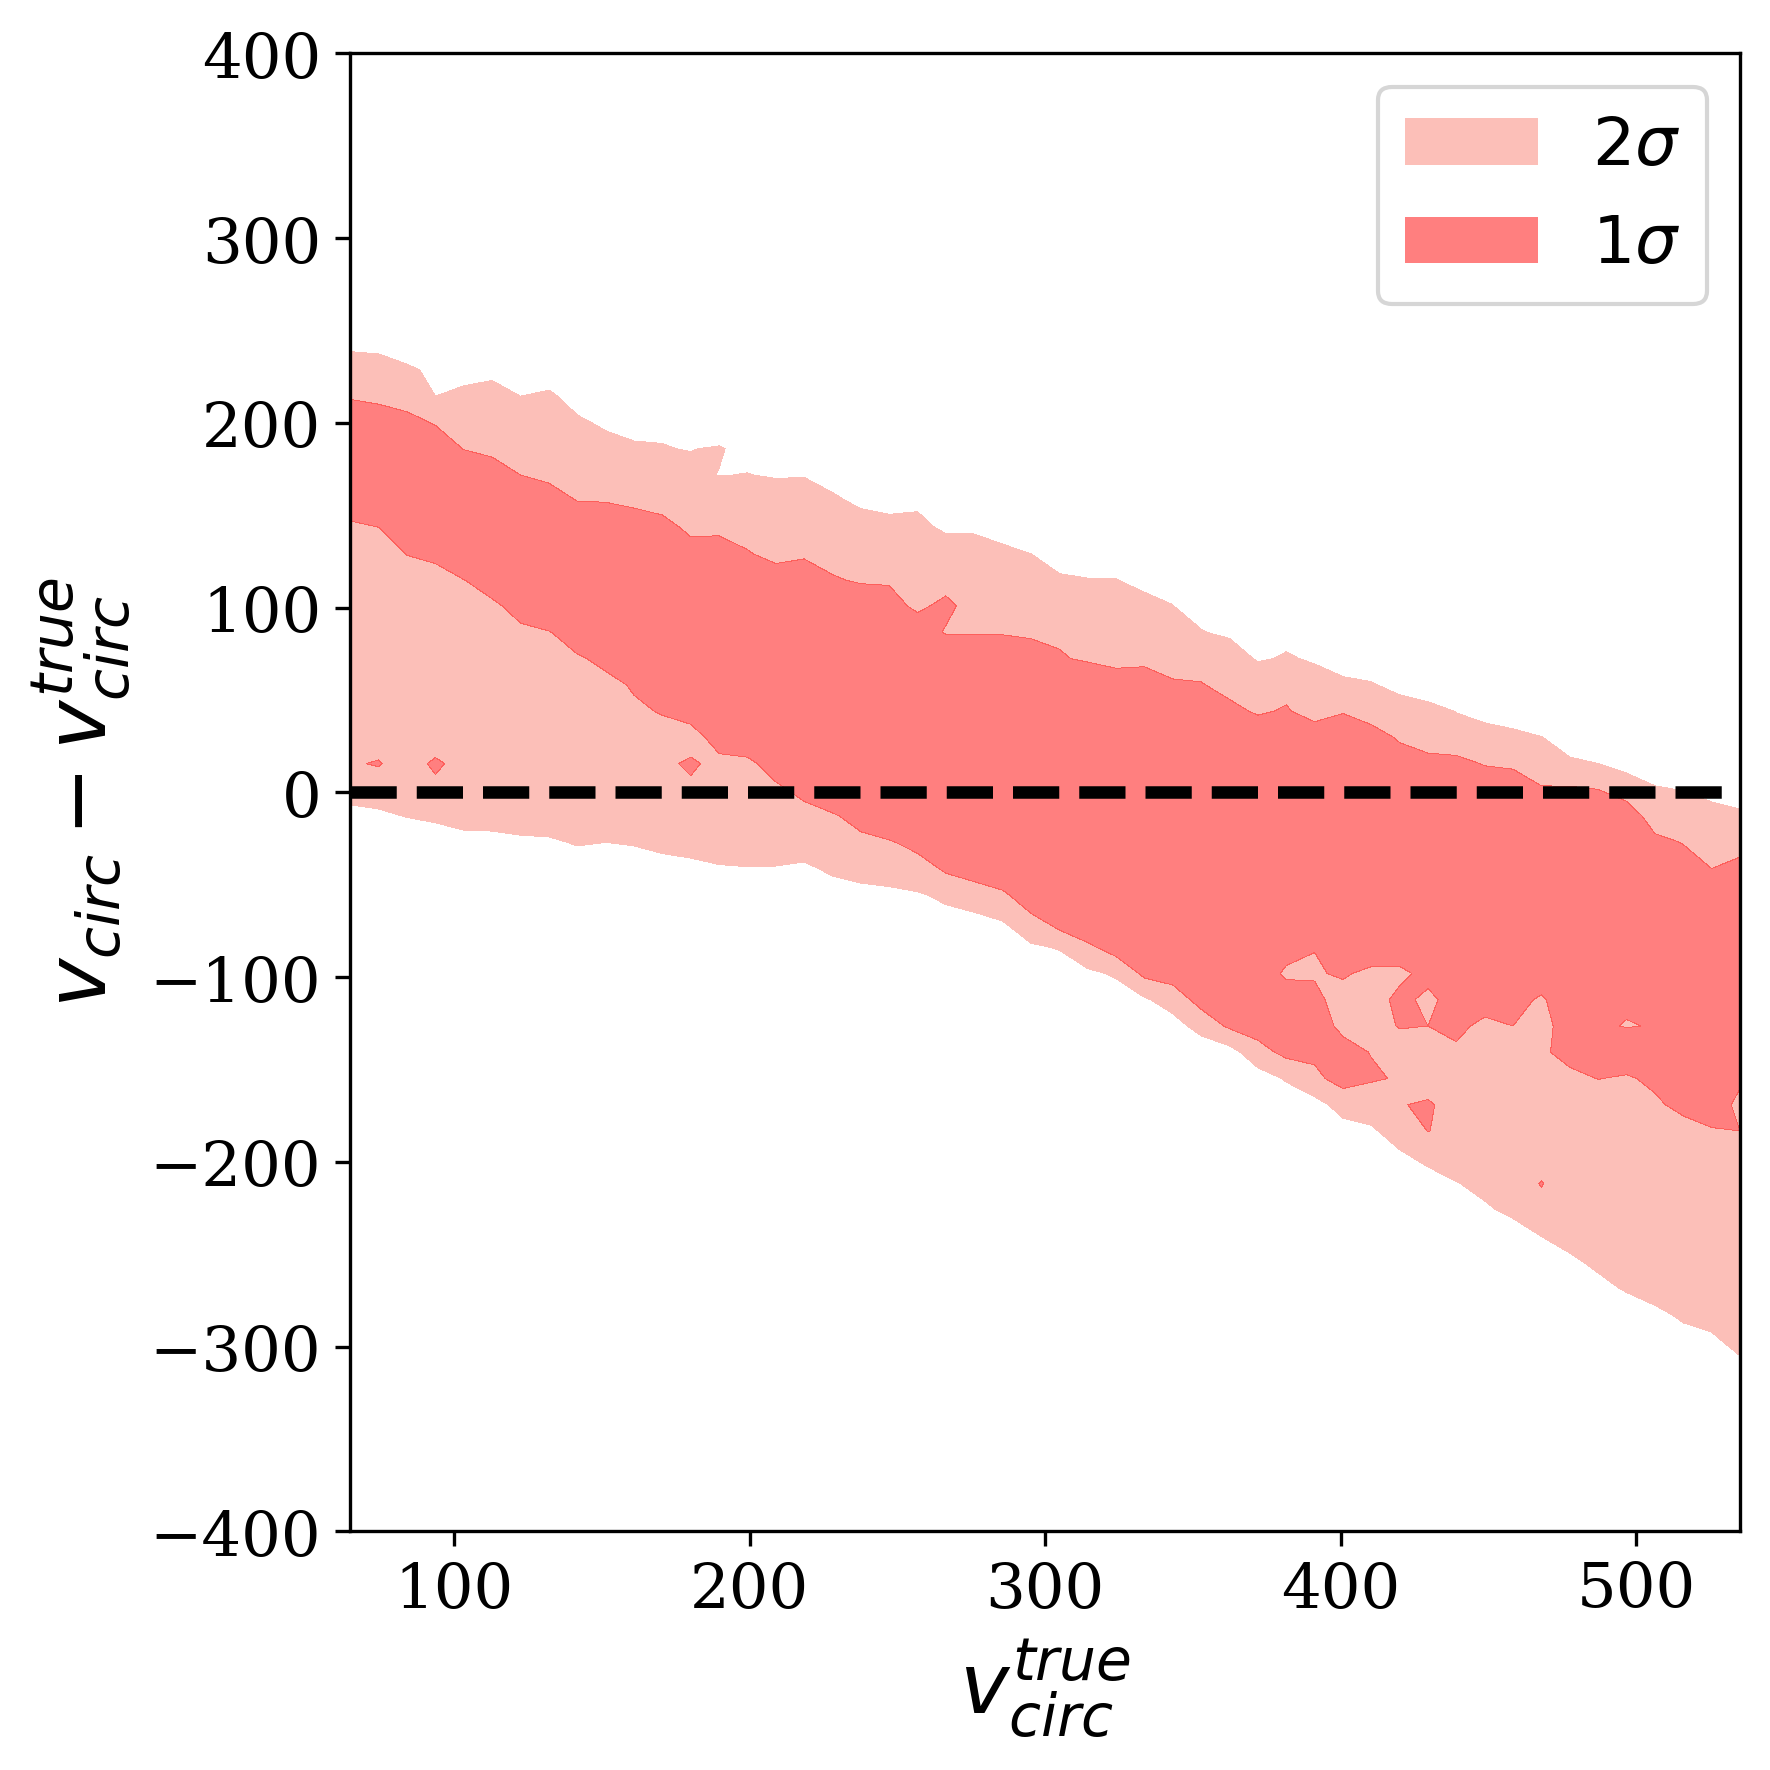

In [29]:
fig = plt.figure(figsize=(6,6))

vcirc_true = true[:,6]
vcirc_diff = diff[:,6]
contour = density_contour(vcirc_true, vcirc_diff, 50, 50, colors=['salmon', 'red'])
plt.ylim(-400,400)

plt.axhline(0,color='k',linestyle='--',linewidth=3)
    
plt.xlabel(r'$v_{circ}^{true}$',fontsize=20)
plt.ylabel(r'$v_{circ}-v_{circ}^{true}$',fontsize=20)

plt.tick_params(axis='both',which='major',labelsize=15)

handles, labels = contour.legend_elements()
plt.legend(handles, [r'$2\sigma$', r'$1\sigma$'], fontsize=16)

plt.tight_layout()
plt.savefig(join(fig_dir, f'{stem}/vcirc_{stem}_contour.jpg'))
plt.show()

### rscale

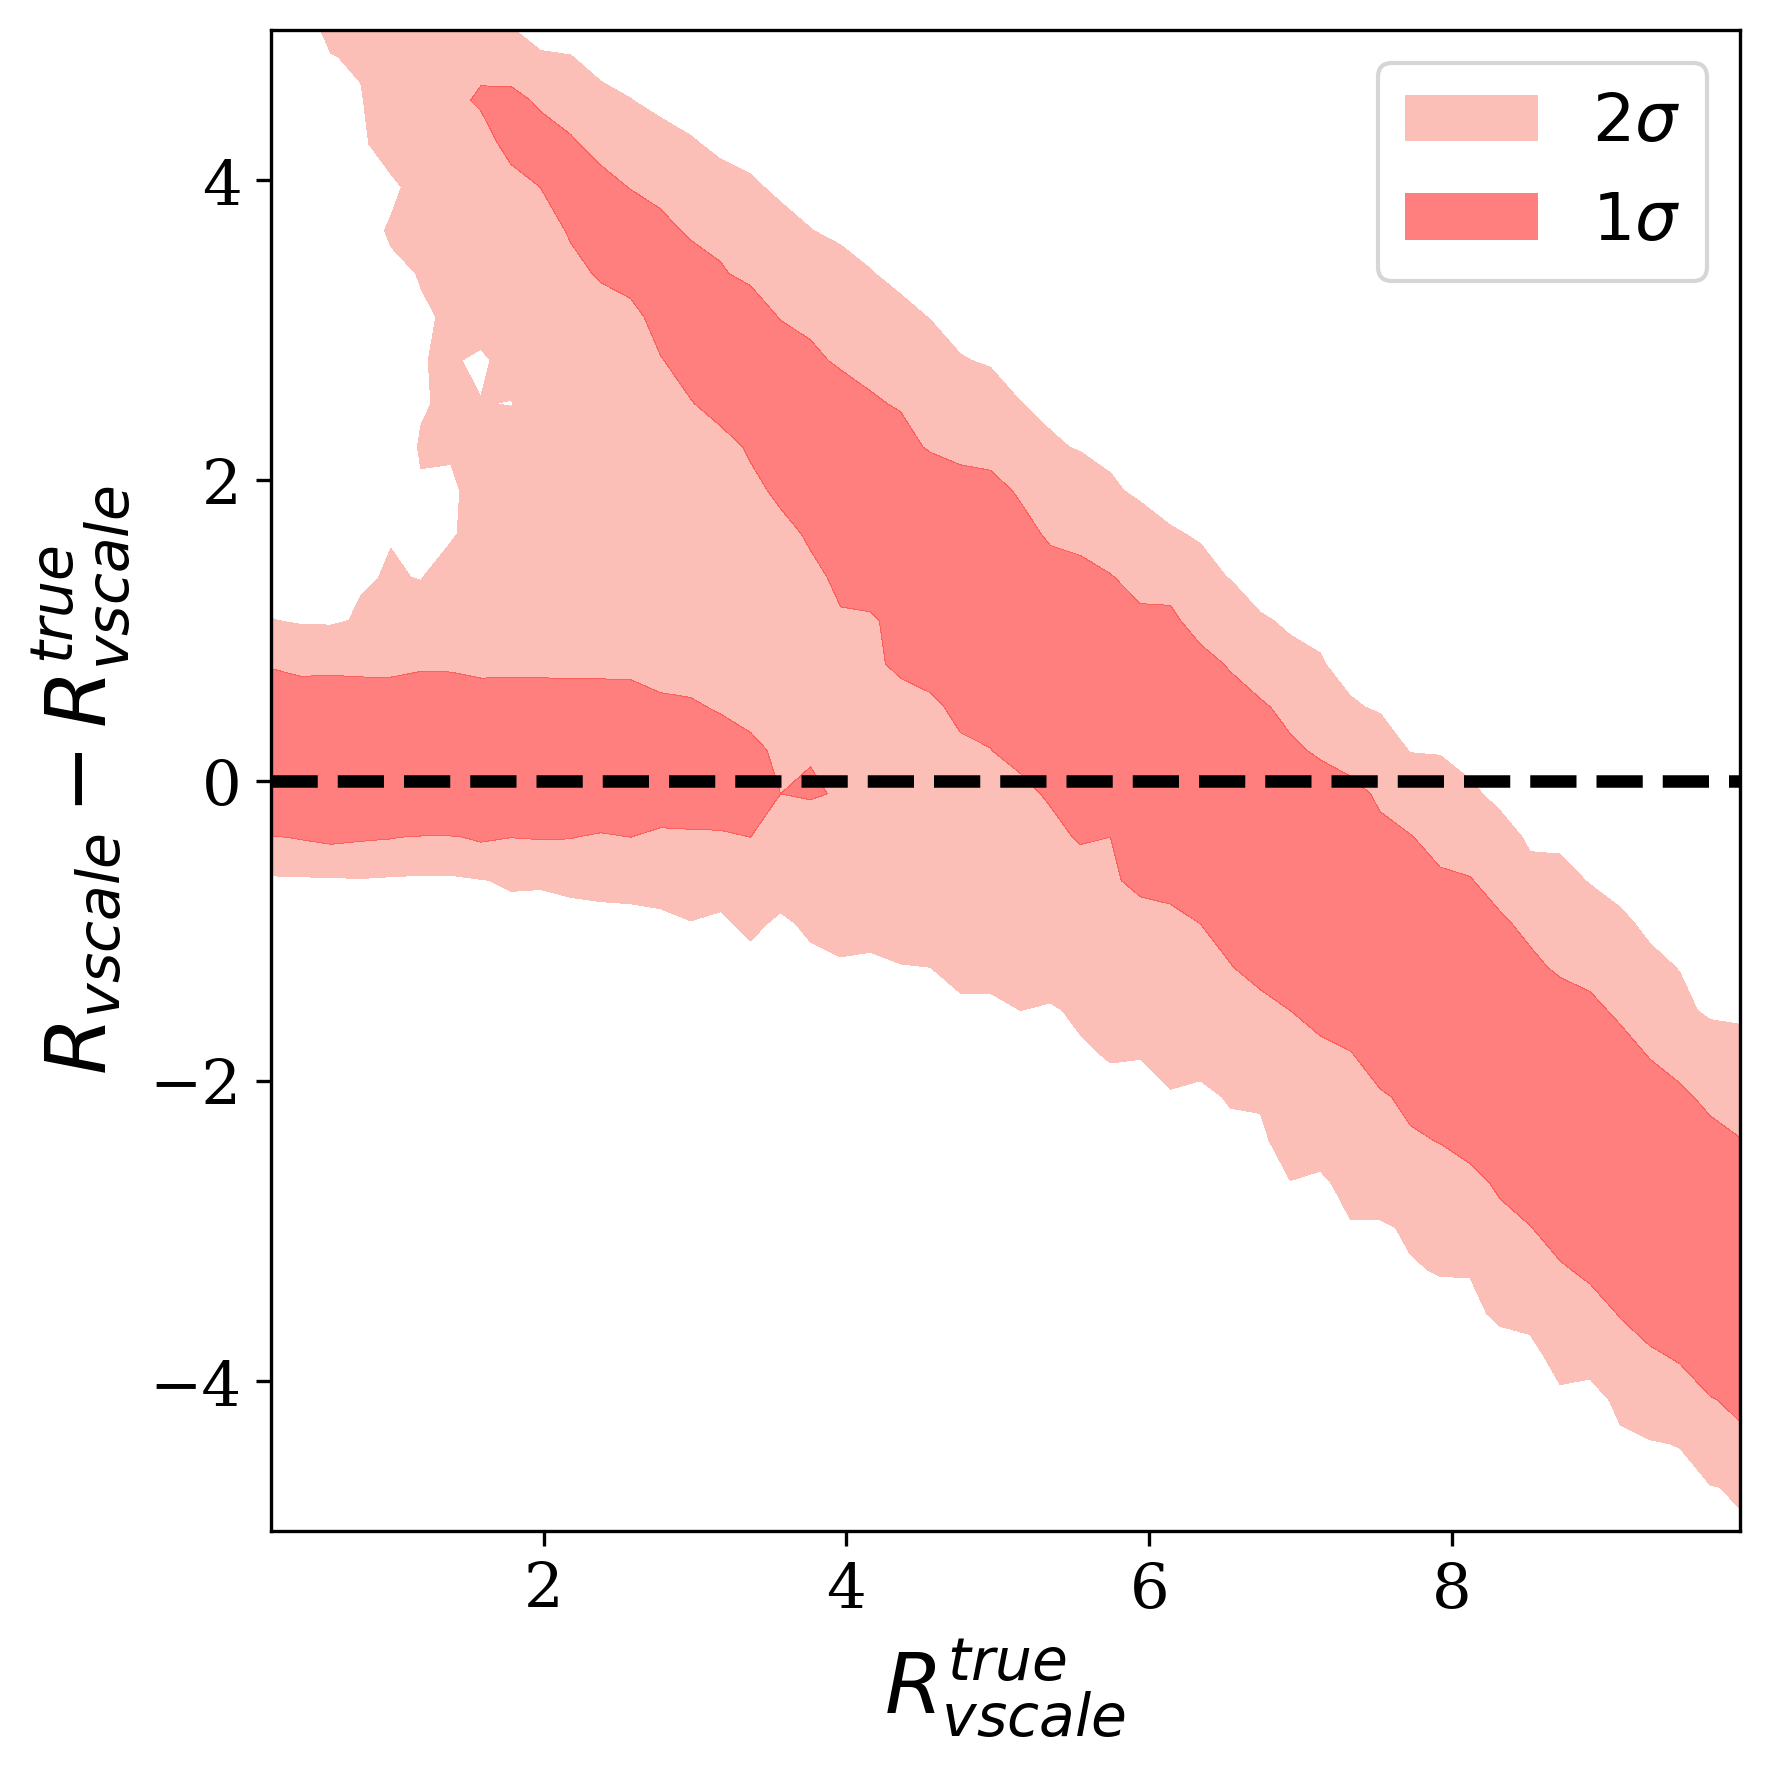

In [30]:
fig = plt.figure(figsize=(6,6))

rscale_true = true[:,7]
rscale_diff = diff[:,7]
contour = density_contour(rscale_true, rscale_diff, 50, 50, colors=['salmon', 'red'])
plt.ylim(-5, 5)

plt.axhline(0,color='k',linestyle='--',linewidth=3)
    
plt.xlabel(r'$R_{vscale}^{true}$',fontsize=20)
plt.ylabel(r'$R_{vscale}-R_{vscale}^{true}$',fontsize=20)

plt.tick_params(axis='both',which='major',labelsize=15)

handles, labels = contour.legend_elements()
plt.legend(handles, [r'$2\sigma$', r'$1\sigma$'], fontsize=16)

plt.tight_layout()
plt.savefig(join(fig_dir, f'{stem}/rscale_{stem}_contour.jpg'))
plt.show()

### hlr

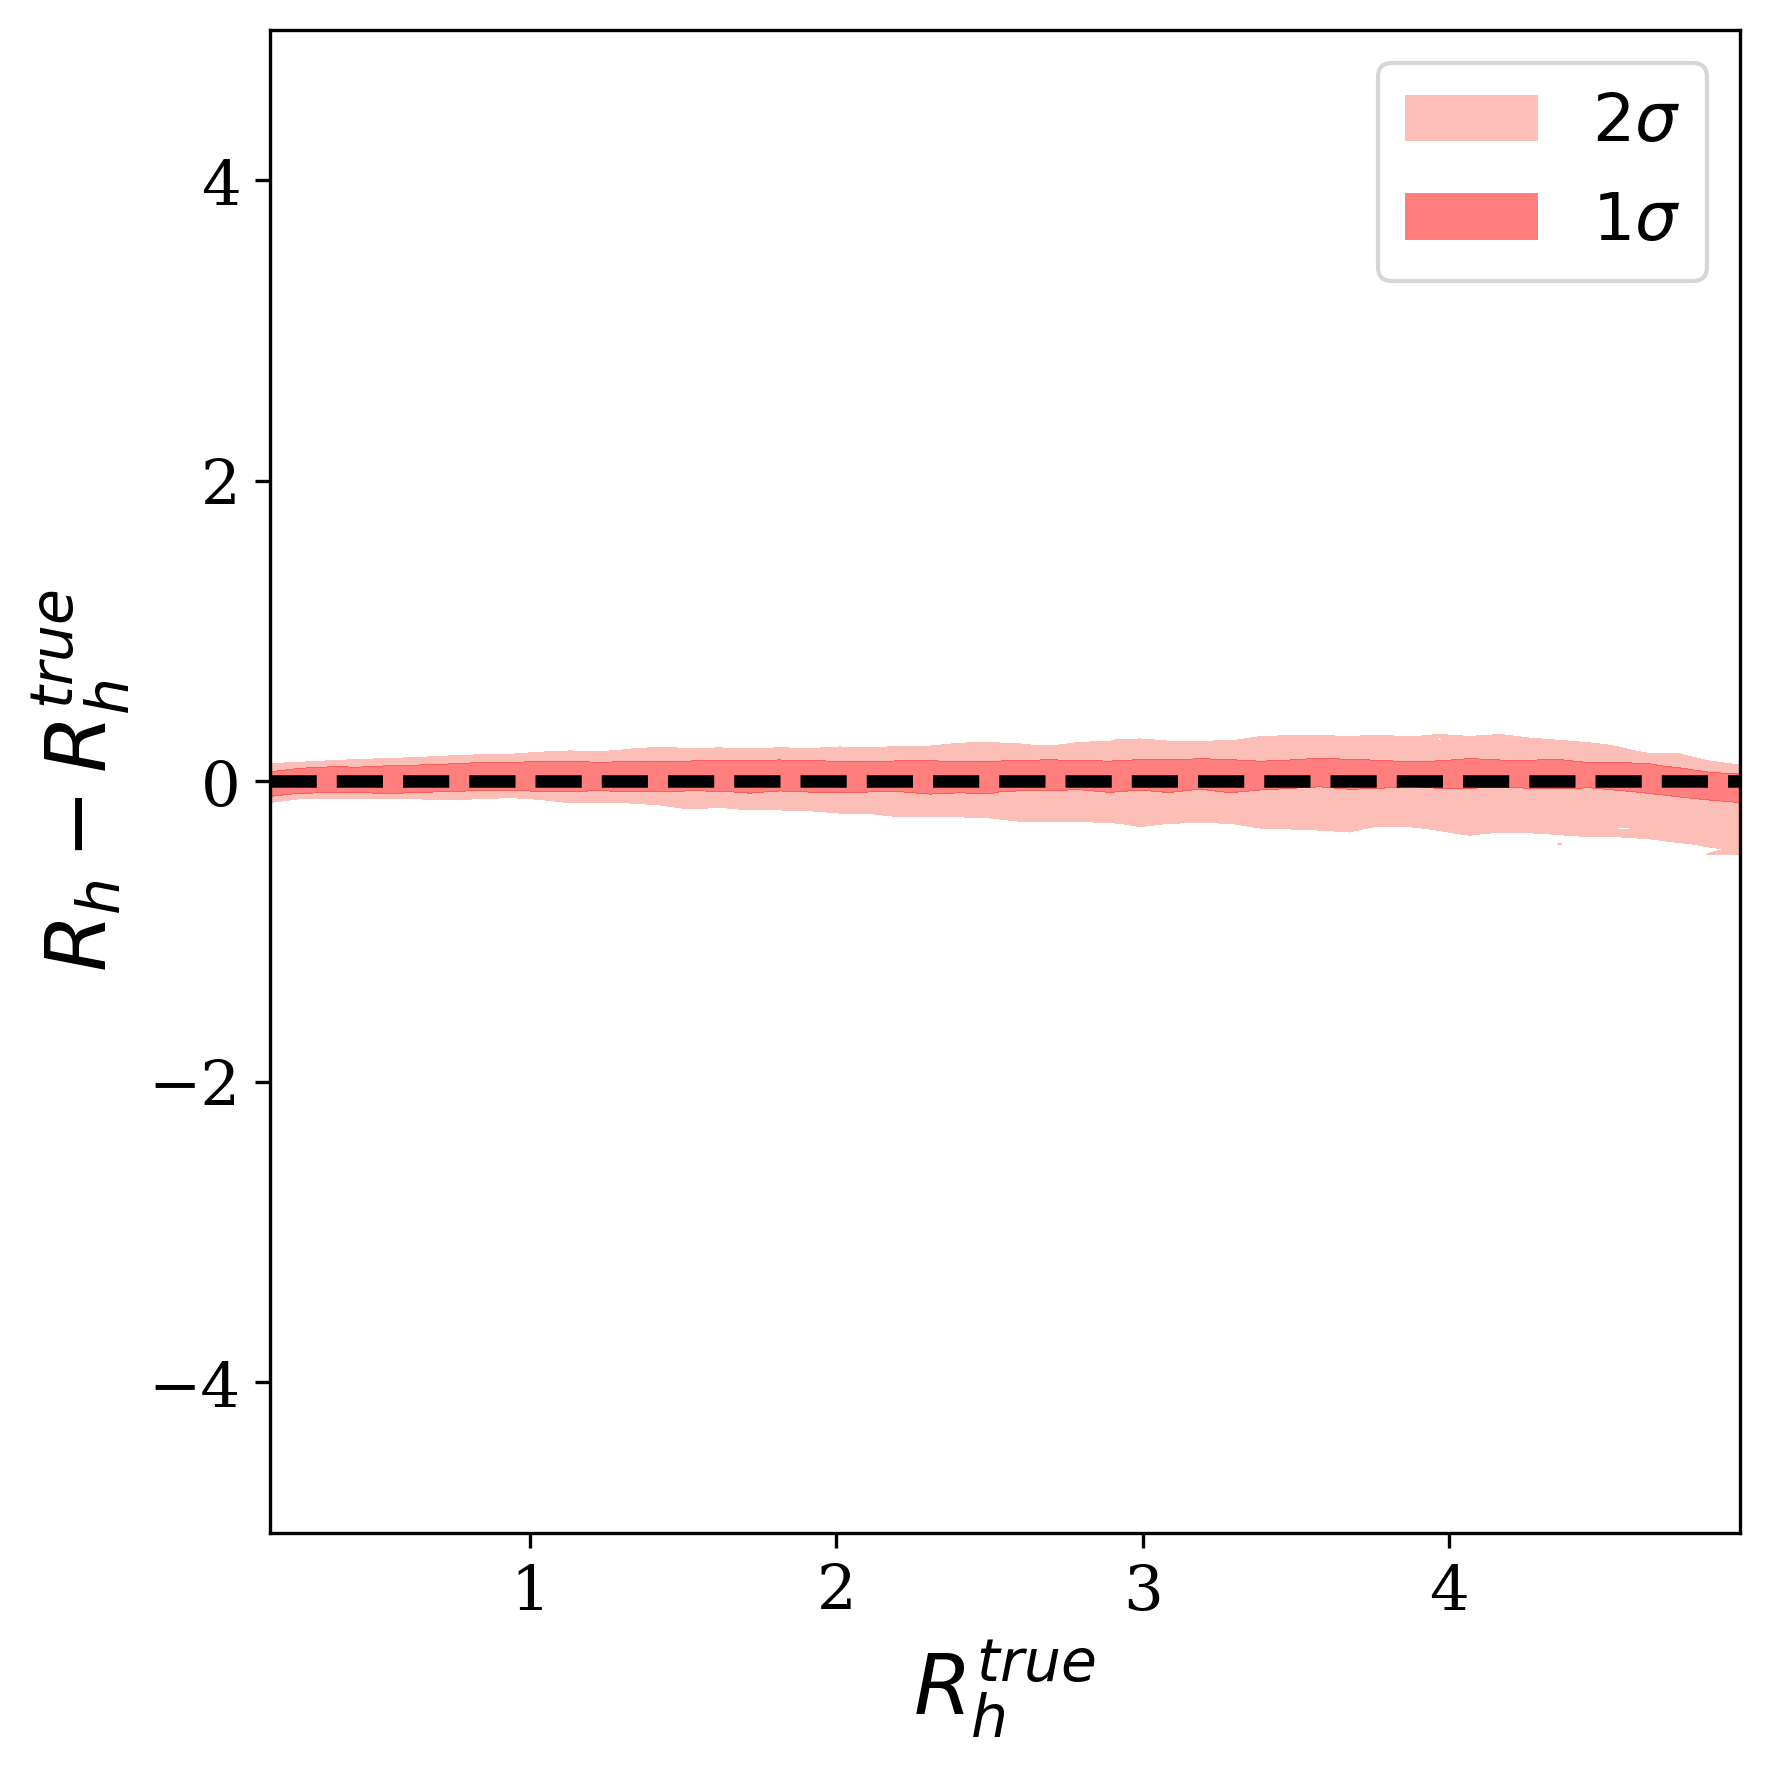

In [31]:
fig = plt.figure(figsize=(6,6))

hlr_true = true[:,8]
hlr_diff = diff[:,8]
contour = density_contour(hlr_true, hlr_diff, 50, 50, colors=['salmon', 'red'])
plt.ylim(-5, 5)

plt.axhline(0,color='k',linestyle='--',linewidth=3)
    
plt.xlabel(r'$R_h^{true}$',fontsize=20)
plt.ylabel(r'$R_h-R_h^{true}$',fontsize=20)

plt.tick_params(axis='both',which='major',labelsize=15)

handles, labels = contour.legend_elements()
plt.legend(handles, [r'$2\sigma$', r'$1\sigma$'], fontsize=16)

plt.tight_layout()
plt.savefig(join(fig_dir, f'{stem}/hlr_{stem}_contour.jpg'))
plt.show()

In [29]:
dividers = [0.2, 0.2, np.pi, 1, 60, 480, 9.9, 4.9]

In [30]:
avg_diff = np.average(np.abs(diff), axis=0)
avg_diff[1:] /= dividers
print(avg_diff)
np.save(join(results_dir, f'avgdiff_{stem}'), avg_diff)

[0.         0.15654195 0.15625391 0.16622671 0.07795268 0.01062704
 0.17060268 0.1543291  0.02031919]
